## 1. 모델 정의

### 1-1. 기본 준비

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
data1 = pd.read_csv('d01_preprocessed_revised.csv')
data2 = pd.read_csv('d02_preprocessed.csv')
data3 = pd.read_csv('d03_preprocessed.csv')

### 1-2. 데이터 증강 및 구조화

In [3]:
for idx, i in enumerate(data2['thought']):
    if type(i) != str:
        data2['thought'][idx] = ''

/tmp/ipython-input-3705106326.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data2['thought'][idx] = ''
/tmp/ipython-input-3705106326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [4]:
data1_1 = data1['situation']+' '+data1['thought']
data1_2 = data1['situation']+' '+data1['reframe']
data2_1 = data2['situation']+' '+data2['thought']
data3_1 = data3['situation']+' '+data3['thought']
data3_2 = data3['situation']+' '+data3['reframe']

In [5]:
data1_1.drop_duplicates(inplace = True)
data1_2.drop_duplicates(inplace = True)
data2_1.drop_duplicates(inplace = True)
data3_1.drop_duplicates(inplace = True)
data3_2.drop_duplicates(inplace = True)

In [6]:
def normalize_text(s):
    # Removing articles and punctuation, and standardizing whitespace
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


In [7]:
from transformers import BertTokenizer, BertModel, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_config = BertConfig.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Embedding

def tokenize_and_pad(data, tokenizer, max_len=512):
    tokenized_data = []
    for text in data:
        encoded = tokenizer(normalize_text(text), return_tensors = "pt", padding='max_length', truncation=True, max_length=max_len)
        tokenized_data.append(encoded)
    return tokenized_data

data1_1_encoded = tokenize_and_pad(data1_1, tokenizer)
data1_2_encoded = tokenize_and_pad(data1_2, tokenizer)
data2_1_encoded = tokenize_and_pad(data2_1, tokenizer)
data3_1_encoded = tokenize_and_pad(data3_1, tokenizer)
data3_2_encoded = tokenize_and_pad(data3_2, tokenizer)

In [9]:
# Add labels
data1_1_labels = list(data1['has_distortion'][data1_1.index])
data2_1_labels = list(data2['has_distortion'][data2_1.index])
data3_1_labels = list(data3['has_distortion'][data3_1.index])

data1_2_labels = [0 for i in range(len(data1_2_encoded))]
data3_2_labels = [0 for i in range(len(data3_2_encoded))]

In [10]:
# Merging Data
data_encoded = data1_1_encoded + data1_2_encoded + data2_1_encoded + data3_1_encoded + data3_2_encoded
data_labels = data1_1_labels + data1_2_labels + data2_1_labels + data3_1_labels + data3_2_labels

In [11]:
class CustomDatasetWithLabels(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {"input_ids": self.data[idx]['input_ids'].squeeze(),
                "attention_mask": self.data[idx]['attention_mask'].squeeze(),
                "y": self.labels[idx]}

In [12]:
dataset_with_labels = CustomDatasetWithLabels(data_encoded, data_labels)

# Define proportions for splitting
train_size = int(0.8 * len(dataset_with_labels))
val_size = int(0.1 * len(dataset_with_labels))
test_size = len(dataset_with_labels) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_with_labels, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

input_dim = bert_config.hidden_size
num_labels = len(set(data_labels))
label_emb = torch.randn(num_labels, input_dim)

### 1-3. 모델 학습과 손실 함수 정의

In [13]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device="cpu"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["y"].to(device)

            # Get embeddings from the BERT model
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

            logits = model(embeddings)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [14]:
# Classifier that uses label embeddings to make predictions
class InnerProductClassifier(nn.Module):
    def __init__(self, input_dim, label_embeddings, trainable_label_emb=True):
        super().__init__()
        # Project input features into the same dimension as label embeddings
        self.proj = nn.Linear(input_dim, label_embeddings.size(1))

        if trainable_label_emb:
            # Label embeddings are trainable parameters
            self.label_emb = nn.Parameter(label_embeddings.clone())
        else:
            # Label embeddings are fixed (not updated during training)
            self.register_buffer("label_emb", label_embeddings.clone())

    def forward(self, x):
        # Project input feature vectors
        x_proj = self.proj(x)
        # Compute logits as similarity with each label embedding
        logits = torch.matmul(x_proj, self.label_emb.T)
        return logits

### 1-4. 모델 생성

In [15]:
# Instantiate the InnerProductClassifier model
model = InnerProductClassifier(input_dim, label_emb).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

## 2. 모델 학습

In [16]:
EPOCHS = 10

# Move the BERT model to the device
bert_model.to(device)

for epoch in range(EPOCHS):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["y"].to(device)

        # Get embeddings from the BERT model
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Pass embeddings to the InnerProductClassifier
        logits = model(embeddings)
        loss = criterion(logits, y)

        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

    # Evaluate on the validation set after each epoch
    val_metrics = evaluate(model, val_dataloader, device)
    print(f"Epoch {epoch} Validation Accuracy: {val_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Epoch 0:   2%|▏         | 1/49 [00:02<01:55,  2.42s/it]

Loss: 5.027010440826416


Epoch 0:   4%|▍         | 2/49 [00:04<01:32,  1.97s/it]

Loss: 13.109464645385742


Epoch 0:   6%|▌         | 3/49 [00:05<01:24,  1.83s/it]

Loss: 8.268026351928711


Epoch 0:   8%|▊         | 4/49 [00:07<01:19,  1.76s/it]

Loss: 4.170319557189941


Epoch 0:  10%|█         | 5/49 [00:09<01:16,  1.73s/it]

Loss: 2.6941962242126465


Epoch 0:  12%|█▏        | 6/49 [00:10<01:13,  1.71s/it]

Loss: 3.914161205291748


Epoch 0:  14%|█▍        | 7/49 [00:12<01:11,  1.71s/it]

Loss: 4.8599114418029785


Epoch 0:  16%|█▋        | 8/49 [00:14<01:09,  1.71s/it]

Loss: 1.6961630582809448


Epoch 0:  18%|█▊        | 9/49 [00:15<01:08,  1.71s/it]

Loss: 1.2210546731948853


Epoch 0:  20%|██        | 10/49 [00:17<01:06,  1.71s/it]

Loss: 2.7191638946533203


Epoch 0:  22%|██▏       | 11/49 [00:19<01:04,  1.71s/it]

Loss: 5.856086730957031


Epoch 0:  24%|██▍       | 12/49 [00:20<01:03,  1.71s/it]

Loss: 3.7503716945648193


Epoch 0:  27%|██▋       | 13/49 [00:22<01:01,  1.71s/it]

Loss: 1.7287874221801758


Epoch 0:  29%|██▊       | 14/49 [00:24<01:00,  1.72s/it]

Loss: 1.1054058074951172


Epoch 0:  31%|███       | 15/49 [00:26<00:58,  1.72s/it]

Loss: 2.0697731971740723


Epoch 0:  33%|███▎      | 16/49 [00:27<00:56,  1.72s/it]

Loss: 2.544100761413574


Epoch 0:  35%|███▍      | 17/49 [00:29<00:55,  1.73s/it]

Loss: 3.865708827972412


Epoch 0:  37%|███▋      | 18/49 [00:31<00:53,  1.74s/it]

Loss: 2.087536334991455


Epoch 0:  39%|███▉      | 19/49 [00:33<00:52,  1.74s/it]

Loss: 1.7660404443740845


Epoch 0:  41%|████      | 20/49 [00:34<00:50,  1.75s/it]

Loss: 1.225574016571045


Epoch 0:  43%|████▎     | 21/49 [00:36<00:48,  1.75s/it]

Loss: 1.632705807685852


Epoch 0:  45%|████▍     | 22/49 [00:38<00:47,  1.75s/it]

Loss: 2.185483455657959


Epoch 0:  47%|████▋     | 23/49 [00:40<00:45,  1.76s/it]

Loss: 1.3588502407073975


Epoch 0:  49%|████▉     | 24/49 [00:41<00:44,  1.76s/it]

Loss: 0.9718450903892517


Epoch 0:  51%|█████     | 25/49 [00:43<00:42,  1.77s/it]

Loss: 1.3322036266326904


Epoch 0:  53%|█████▎    | 26/49 [00:45<00:40,  1.78s/it]

Loss: 1.8914766311645508


Epoch 0:  55%|█████▌    | 27/49 [00:47<00:39,  1.79s/it]

Loss: 2.2196929454803467


Epoch 0:  57%|█████▋    | 28/49 [00:49<00:37,  1.80s/it]

Loss: 1.3773343563079834


Epoch 0:  59%|█████▉    | 29/49 [00:50<00:36,  1.81s/it]

Loss: 0.47187143564224243


Epoch 0:  61%|██████    | 30/49 [00:52<00:34,  1.82s/it]

Loss: 1.1677110195159912


Epoch 0:  63%|██████▎   | 31/49 [00:54<00:32,  1.83s/it]

Loss: 1.0132009983062744


Epoch 0:  65%|██████▌   | 32/49 [00:56<00:31,  1.84s/it]

Loss: 1.6713088750839233


Epoch 0:  67%|██████▋   | 33/49 [00:58<00:29,  1.85s/it]

Loss: 1.386617660522461


Epoch 0:  69%|██████▉   | 34/49 [01:00<00:27,  1.86s/it]

Loss: 0.35872676968574524


Epoch 0:  71%|███████▏  | 35/49 [01:02<00:26,  1.88s/it]

Loss: 0.9685781598091125


Epoch 0:  73%|███████▎  | 36/49 [01:04<00:24,  1.89s/it]

Loss: 0.7466984987258911


Epoch 0:  76%|███████▌  | 37/49 [01:06<00:22,  1.90s/it]

Loss: 0.9643214344978333


Epoch 0:  78%|███████▊  | 38/49 [01:08<00:21,  1.91s/it]

Loss: 1.0031952857971191


Epoch 0:  80%|███████▉  | 39/49 [01:09<00:19,  1.92s/it]

Loss: 1.887741208076477


Epoch 0:  82%|████████▏ | 40/49 [01:11<00:17,  1.93s/it]

Loss: 0.6436048746109009


Epoch 0:  84%|████████▎ | 41/49 [01:13<00:15,  1.94s/it]

Loss: 1.2087247371673584


Epoch 0:  86%|████████▌ | 42/49 [01:15<00:13,  1.95s/it]

Loss: 2.480705976486206


Epoch 0:  88%|████████▊ | 43/49 [01:17<00:11,  1.95s/it]

Loss: 1.131577491760254


Epoch 0:  90%|████████▉ | 44/49 [01:19<00:09,  1.95s/it]

Loss: 1.5761020183563232


Epoch 0:  92%|█████████▏| 45/49 [01:21<00:07,  1.95s/it]

Loss: 0.7759994268417358


Epoch 0:  94%|█████████▍| 46/49 [01:23<00:05,  1.94s/it]

Loss: 1.7943174839019775


Epoch 0:  96%|█████████▌| 47/49 [01:25<00:03,  1.94s/it]

Loss: 1.181957483291626


Epoch 0:  98%|█████████▊| 48/49 [01:27<00:01,  1.93s/it]

Loss: 1.3138818740844727


Epoch 0: 100%|██████████| 49/49 [01:27<00:00,  1.80s/it]

Loss: 1.1044902801513672


Epoch 0 Validation Accuracy: 0.8367875647668394, F1-macro: 0.8343313781193158


Epoch 1:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 1.3693554401397705


Epoch 1:   4%|▍         | 2/49 [00:03<01:27,  1.85s/it]

Loss: 1.0184967517852783


Epoch 1:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 1.2544732093811035


Epoch 1:   8%|▊         | 4/49 [00:07<01:23,  1.85s/it]

Loss: 0.8619619011878967


Epoch 1:  10%|█         | 5/49 [00:09<01:21,  1.84s/it]

Loss: 0.5352067947387695


Epoch 1:  12%|█▏        | 6/49 [00:11<01:19,  1.84s/it]

Loss: 0.47802606225013733


Epoch 1:  14%|█▍        | 7/49 [00:12<01:17,  1.84s/it]

Loss: 0.9192355275154114


Epoch 1:  16%|█▋        | 8/49 [00:14<01:15,  1.84s/it]

Loss: 0.5296812653541565


Epoch 1:  18%|█▊        | 9/49 [00:16<01:13,  1.84s/it]

Loss: 1.2987022399902344


Epoch 1:  20%|██        | 10/49 [00:18<01:11,  1.84s/it]

Loss: 0.4554450809955597


Epoch 1:  22%|██▏       | 11/49 [00:20<01:09,  1.84s/it]

Loss: 0.5018355846405029


Epoch 1:  24%|██▍       | 12/49 [00:22<01:08,  1.84s/it]

Loss: 0.26399698853492737


Epoch 1:  27%|██▋       | 13/49 [00:23<01:06,  1.84s/it]

Loss: 0.5892140865325928


Epoch 1:  29%|██▊       | 14/49 [00:25<01:04,  1.84s/it]

Loss: 0.4913518726825714


Epoch 1:  31%|███       | 15/49 [00:27<01:02,  1.84s/it]

Loss: 0.55521160364151


Epoch 1:  33%|███▎      | 16/49 [00:29<01:00,  1.85s/it]

Loss: 0.5487468838691711


Epoch 1:  35%|███▍      | 17/49 [00:31<00:59,  1.85s/it]

Loss: 0.7227709293365479


Epoch 1:  37%|███▋      | 18/49 [00:33<00:57,  1.85s/it]

Loss: 0.7350881695747375


Epoch 1:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 1.0140546560287476


Epoch 1:  41%|████      | 20/49 [00:36<00:53,  1.86s/it]

Loss: 1.2589597702026367


Epoch 1:  43%|████▎     | 21/49 [00:38<00:52,  1.86s/it]

Loss: 0.653949499130249


Epoch 1:  45%|████▍     | 22/49 [00:40<00:50,  1.87s/it]

Loss: 0.9288033246994019


Epoch 1:  47%|████▋     | 23/49 [00:42<00:48,  1.87s/it]

Loss: 0.5560523271560669


Epoch 1:  49%|████▉     | 24/49 [00:44<00:46,  1.87s/it]

Loss: 0.23861339688301086


Epoch 1:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.7428048849105835


Epoch 1:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.449119508266449


Epoch 1:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.5418869256973267


Epoch 1:  57%|█████▋    | 28/49 [00:51<00:39,  1.88s/it]

Loss: 0.8639271259307861


Epoch 1:  59%|█████▉    | 29/49 [00:53<00:37,  1.88s/it]

Loss: 0.3357993960380554


Epoch 1:  61%|██████    | 30/49 [00:55<00:35,  1.89s/it]

Loss: 0.30679261684417725


Epoch 1:  63%|██████▎   | 31/49 [00:57<00:33,  1.89s/it]

Loss: 0.8112550973892212


Epoch 1:  65%|██████▌   | 32/49 [00:59<00:32,  1.89s/it]

Loss: 0.48438018560409546


Epoch 1:  67%|██████▋   | 33/49 [01:01<00:30,  1.89s/it]

Loss: 0.4691482186317444


Epoch 1:  69%|██████▉   | 34/49 [01:03<00:28,  1.89s/it]

Loss: 0.5568572282791138


Epoch 1:  71%|███████▏  | 35/49 [01:05<00:26,  1.89s/it]

Loss: 0.4492945671081543


Epoch 1:  73%|███████▎  | 36/49 [01:07<00:24,  1.89s/it]

Loss: 0.5801134705543518


Epoch 1:  76%|███████▌  | 37/49 [01:08<00:22,  1.89s/it]

Loss: 0.6023279428482056


Epoch 1:  78%|███████▊  | 38/49 [01:10<00:20,  1.88s/it]

Loss: 0.4714179039001465


Epoch 1:  80%|███████▉  | 39/49 [01:12<00:18,  1.88s/it]

Loss: 0.48974722623825073


Epoch 1:  82%|████████▏ | 40/49 [01:14<00:16,  1.88s/it]

Loss: 0.4189227223396301


Epoch 1:  84%|████████▎ | 41/49 [01:16<00:15,  1.88s/it]

Loss: 0.7429366111755371


Epoch 1:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.3771839737892151


Epoch 1:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.8237246870994568


Epoch 1:  90%|████████▉ | 44/49 [01:22<00:09,  1.87s/it]

Loss: 0.5813797116279602


Epoch 1:  92%|█████████▏| 45/49 [01:23<00:07,  1.87s/it]

Loss: 0.5917662382125854


Epoch 1:  94%|█████████▍| 46/49 [01:25<00:05,  1.87s/it]

Loss: 0.673534631729126


Epoch 1:  96%|█████████▌| 47/49 [01:27<00:03,  1.87s/it]

Loss: 0.37132900953292847


Epoch 1:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.21361632645130157


Epoch 1: 100%|██████████| 49/49 [01:30<00:00,  1.84s/it]

Loss: 0.659866988658905


Epoch 1 Validation Accuracy: 0.810880829015544, F1-macro: 0.8089303271740973


Epoch 2:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.6479548215866089


Epoch 2:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 0.6090772151947021


Epoch 2:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 0.31331270933151245


Epoch 2:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.9674497842788696


Epoch 2:  10%|█         | 5/49 [00:09<01:22,  1.86s/it]

Loss: 0.4010268449783325


Epoch 2:  12%|█▏        | 6/49 [00:11<01:20,  1.87s/it]

Loss: 0.6835461854934692


Epoch 2:  14%|█▍        | 7/49 [00:13<01:18,  1.87s/it]

Loss: 0.2812637984752655


Epoch 2:  16%|█▋        | 8/49 [00:14<01:16,  1.87s/it]

Loss: 0.42898091673851013


Epoch 2:  18%|█▊        | 9/49 [00:16<01:14,  1.87s/it]

Loss: 0.7872331142425537


Epoch 2:  20%|██        | 10/49 [00:18<01:12,  1.87s/it]

Loss: 0.1321113109588623


Epoch 2:  22%|██▏       | 11/49 [00:20<01:11,  1.87s/it]

Loss: 0.3531850278377533


Epoch 2:  24%|██▍       | 12/49 [00:22<01:09,  1.87s/it]

Loss: 0.63154536485672


Epoch 2:  27%|██▋       | 13/49 [00:24<01:07,  1.87s/it]

Loss: 0.22016645967960358


Epoch 2:  29%|██▊       | 14/49 [00:26<01:05,  1.87s/it]

Loss: 0.19096481800079346


Epoch 2:  31%|███       | 15/49 [00:28<01:03,  1.87s/it]

Loss: 0.7139280438423157


Epoch 2:  33%|███▎      | 16/49 [00:29<01:01,  1.87s/it]

Loss: 0.3616863489151001


Epoch 2:  35%|███▍      | 17/49 [00:31<00:59,  1.87s/it]

Loss: 0.39685410261154175


Epoch 2:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.4565158188343048


Epoch 2:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.5621343851089478


Epoch 2:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 0.26904234290122986


Epoch 2:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.5416459441184998


Epoch 2:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.8158586025238037


Epoch 2:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.386802077293396


Epoch 2:  49%|████▉     | 24/49 [00:44<00:46,  1.88s/it]

Loss: 0.626599907875061


Epoch 2:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.7873818874359131


Epoch 2:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.7126652002334595


Epoch 2:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 1.0066536664962769


Epoch 2:  57%|█████▋    | 28/49 [00:52<00:39,  1.88s/it]

Loss: 1.1317343711853027


Epoch 2:  59%|█████▉    | 29/49 [00:54<00:37,  1.88s/it]

Loss: 0.3938976526260376


Epoch 2:  61%|██████    | 30/49 [00:56<00:35,  1.88s/it]

Loss: 1.1940057277679443


Epoch 2:  63%|██████▎   | 31/49 [00:58<00:33,  1.88s/it]

Loss: 0.5343342423439026


Epoch 2:  65%|██████▌   | 32/49 [00:59<00:31,  1.88s/it]

Loss: 0.3955119848251343


Epoch 2:  67%|██████▋   | 33/49 [01:01<00:30,  1.88s/it]

Loss: 1.2084453105926514


Epoch 2:  69%|██████▉   | 34/49 [01:03<00:28,  1.88s/it]

Loss: 0.21082350611686707


Epoch 2:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.8575184345245361


Epoch 2:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.6525728106498718


Epoch 2:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.4380141496658325


Epoch 2:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.5943092107772827


Epoch 2:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.6887866854667664


Epoch 2:  82%|████████▏ | 40/49 [01:14<00:16,  1.87s/it]

Loss: 0.24885107576847076


Epoch 2:  84%|████████▎ | 41/49 [01:16<00:14,  1.87s/it]

Loss: 0.678917646408081


Epoch 2:  86%|████████▌ | 42/49 [01:18<00:13,  1.87s/it]

Loss: 0.9121567606925964


Epoch 2:  88%|████████▊ | 43/49 [01:20<00:11,  1.87s/it]

Loss: 0.48772940039634705


Epoch 2:  90%|████████▉ | 44/49 [01:22<00:09,  1.87s/it]

Loss: 0.7927647829055786


Epoch 2:  92%|█████████▏| 45/49 [01:24<00:07,  1.87s/it]

Loss: 0.4864553213119507


Epoch 2:  94%|█████████▍| 46/49 [01:26<00:05,  1.87s/it]

Loss: 0.572539746761322


Epoch 2:  96%|█████████▌| 47/49 [01:28<00:03,  1.87s/it]

Loss: 0.48320192098617554


Epoch 2:  98%|█████████▊| 48/49 [01:29<00:01,  1.87s/it]

Loss: 0.4998110830783844


Epoch 2: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 1.561888575553894


Epoch 2 Validation Accuracy: 0.8290155440414507, F1-macro: 0.8276785714285715


Epoch 3:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.576082706451416


Epoch 3:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 1.3047428131103516


Epoch 3:   6%|▌         | 3/49 [00:05<01:25,  1.86s/it]

Loss: 0.8325855731964111


Epoch 3:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.3328050971031189


Epoch 3:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 1.0152921676635742


Epoch 3:  12%|█▏        | 6/49 [00:11<01:20,  1.86s/it]

Loss: 0.871802806854248


Epoch 3:  14%|█▍        | 7/49 [00:13<01:18,  1.86s/it]

Loss: 0.5410935282707214


Epoch 3:  16%|█▋        | 8/49 [00:14<01:16,  1.87s/it]

Loss: 0.48534297943115234


Epoch 3:  18%|█▊        | 9/49 [00:16<01:14,  1.87s/it]

Loss: 1.0227863788604736


Epoch 3:  20%|██        | 10/49 [00:18<01:12,  1.87s/it]

Loss: 1.346511721611023


Epoch 3:  22%|██▏       | 11/49 [00:20<01:10,  1.87s/it]

Loss: 0.3693847060203552


Epoch 3:  24%|██▍       | 12/49 [00:22<01:09,  1.87s/it]

Loss: 0.4072696566581726


Epoch 3:  27%|██▋       | 13/49 [00:24<01:07,  1.87s/it]

Loss: 0.15347597002983093


Epoch 3:  29%|██▊       | 14/49 [00:26<01:05,  1.87s/it]

Loss: 0.20898132026195526


Epoch 3:  31%|███       | 15/49 [00:27<01:03,  1.87s/it]

Loss: 0.552230715751648


Epoch 3:  33%|███▎      | 16/49 [00:29<01:01,  1.87s/it]

Loss: 0.5677955150604248


Epoch 3:  35%|███▍      | 17/49 [00:31<00:59,  1.87s/it]

Loss: 0.7327942252159119


Epoch 3:  37%|███▋      | 18/49 [00:33<00:57,  1.87s/it]

Loss: 0.3860427737236023


Epoch 3:  39%|███▉      | 19/49 [00:35<00:56,  1.87s/it]

Loss: 1.231688141822815


Epoch 3:  41%|████      | 20/49 [00:37<00:54,  1.87s/it]

Loss: 0.2433416098356247


Epoch 3:  43%|████▎     | 21/49 [00:39<00:52,  1.87s/it]

Loss: 0.3714190423488617


Epoch 3:  45%|████▍     | 22/49 [00:41<00:50,  1.87s/it]

Loss: 0.42390796542167664


Epoch 3:  47%|████▋     | 23/49 [00:42<00:48,  1.87s/it]

Loss: 0.5830687880516052


Epoch 3:  49%|████▉     | 24/49 [00:44<00:46,  1.87s/it]

Loss: 0.26187142729759216


Epoch 3:  51%|█████     | 25/49 [00:46<00:44,  1.87s/it]

Loss: 0.4937449097633362


Epoch 3:  53%|█████▎    | 26/49 [00:48<00:43,  1.87s/it]

Loss: 0.3842364549636841


Epoch 3:  55%|█████▌    | 27/49 [00:50<00:41,  1.87s/it]

Loss: 0.7165172696113586


Epoch 3:  57%|█████▋    | 28/49 [00:52<00:39,  1.87s/it]

Loss: 0.6845605969429016


Epoch 3:  59%|█████▉    | 29/49 [00:54<00:37,  1.87s/it]

Loss: 0.2285061776638031


Epoch 3:  61%|██████    | 30/49 [00:56<00:35,  1.87s/it]

Loss: 0.29797840118408203


Epoch 3:  63%|██████▎   | 31/49 [00:57<00:33,  1.87s/it]

Loss: 0.4155786335468292


Epoch 3:  65%|██████▌   | 32/49 [00:59<00:31,  1.87s/it]

Loss: 0.3258485794067383


Epoch 3:  67%|██████▋   | 33/49 [01:01<00:29,  1.87s/it]

Loss: 0.24965211749076843


Epoch 3:  69%|██████▉   | 34/49 [01:03<00:28,  1.87s/it]

Loss: 0.3974257707595825


Epoch 3:  71%|███████▏  | 35/49 [01:05<00:26,  1.87s/it]

Loss: 0.5726171731948853


Epoch 3:  73%|███████▎  | 36/49 [01:07<00:24,  1.87s/it]

Loss: 0.38005679845809937


Epoch 3:  76%|███████▌  | 37/49 [01:09<00:22,  1.87s/it]

Loss: 0.36547496914863586


Epoch 3:  78%|███████▊  | 38/49 [01:11<00:20,  1.87s/it]

Loss: 0.8952143788337708


Epoch 3:  80%|███████▉  | 39/49 [01:12<00:18,  1.87s/it]

Loss: 0.43076032400131226


Epoch 3:  82%|████████▏ | 40/49 [01:14<00:16,  1.87s/it]

Loss: 1.2515345811843872


Epoch 3:  84%|████████▎ | 41/49 [01:16<00:14,  1.87s/it]

Loss: 0.6829319000244141


Epoch 3:  86%|████████▌ | 42/49 [01:18<00:13,  1.87s/it]

Loss: 0.5000701546669006


Epoch 3:  88%|████████▊ | 43/49 [01:20<00:11,  1.87s/it]

Loss: 0.8089979887008667


Epoch 3:  90%|████████▉ | 44/49 [01:22<00:09,  1.87s/it]

Loss: 0.9246306419372559


Epoch 3:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.2839043438434601


Epoch 3:  94%|█████████▍| 46/49 [01:26<00:05,  1.87s/it]

Loss: 0.6147629022598267


Epoch 3:  96%|█████████▌| 47/49 [01:27<00:03,  1.87s/it]

Loss: 0.8247395753860474


Epoch 3:  98%|█████████▊| 48/49 [01:29<00:01,  1.87s/it]

Loss: 0.31882137060165405


Epoch 3: 100%|██████████| 49/49 [01:30<00:00,  1.84s/it]

Loss: 1.0006752014160156


Epoch 3 Validation Accuracy: 0.8652849740932642, F1-macro: 0.8645723693088279


Epoch 4:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 0.5258856415748596


Epoch 4:   4%|▍         | 2/49 [00:03<01:28,  1.87s/it]

Loss: 0.3891938328742981


Epoch 4:   6%|▌         | 3/49 [00:05<01:26,  1.87s/it]

Loss: 0.44386106729507446


Epoch 4:   8%|▊         | 4/49 [00:07<01:24,  1.88s/it]

Loss: 0.10916642099618912


Epoch 4:  10%|█         | 5/49 [00:09<01:22,  1.88s/it]

Loss: 0.31818580627441406


Epoch 4:  12%|█▏        | 6/49 [00:11<01:20,  1.88s/it]

Loss: 0.5828904509544373


Epoch 4:  14%|█▍        | 7/49 [00:13<01:18,  1.88s/it]

Loss: 0.254648894071579


Epoch 4:  16%|█▋        | 8/49 [00:15<01:16,  1.88s/it]

Loss: 0.12046944350004196


Epoch 4:  18%|█▊        | 9/49 [00:16<01:15,  1.88s/it]

Loss: 0.17578862607479095


Epoch 4:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 0.5809904336929321


Epoch 4:  22%|██▏       | 11/49 [00:20<01:11,  1.88s/it]

Loss: 0.30200284719467163


Epoch 4:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 0.2558048665523529


Epoch 4:  27%|██▋       | 13/49 [00:24<01:07,  1.88s/it]

Loss: 0.1707700788974762


Epoch 4:  29%|██▊       | 14/49 [00:26<01:05,  1.88s/it]

Loss: 0.3050375282764435


Epoch 4:  31%|███       | 15/49 [00:28<01:03,  1.88s/it]

Loss: 0.4521864652633667


Epoch 4:  33%|███▎      | 16/49 [00:30<01:01,  1.88s/it]

Loss: 0.3119620978832245


Epoch 4:  35%|███▍      | 17/49 [00:31<01:00,  1.88s/it]

Loss: 0.2576823830604553


Epoch 4:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.4522832930088043


Epoch 4:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.20656850934028625


Epoch 4:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 0.3759841322898865


Epoch 4:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.6348651051521301


Epoch 4:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.17068715393543243


Epoch 4:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.277097225189209


Epoch 4:  49%|████▉     | 24/49 [00:45<00:46,  1.88s/it]

Loss: 0.1510009765625


Epoch 4:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.5330488681793213


Epoch 4:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.41478970646858215


Epoch 4:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.13939139246940613


Epoch 4:  57%|█████▋    | 28/49 [00:52<00:39,  1.88s/it]

Loss: 0.4452834129333496


Epoch 4:  59%|█████▉    | 29/49 [00:54<00:37,  1.88s/it]

Loss: 0.2872382402420044


Epoch 4:  61%|██████    | 30/49 [00:56<00:35,  1.88s/it]

Loss: 0.5063654780387878


Epoch 4:  63%|██████▎   | 31/49 [00:58<00:33,  1.88s/it]

Loss: 0.18424105644226074


Epoch 4:  65%|██████▌   | 32/49 [01:00<00:31,  1.88s/it]

Loss: 0.3046051859855652


Epoch 4:  67%|██████▋   | 33/49 [01:01<00:30,  1.88s/it]

Loss: 0.17252758145332336


Epoch 4:  69%|██████▉   | 34/49 [01:03<00:28,  1.88s/it]

Loss: 0.2038814276456833


Epoch 4:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.3929425776004791


Epoch 4:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.40477585792541504


Epoch 4:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.35157135128974915


Epoch 4:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.19781671464443207


Epoch 4:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.5971530675888062


Epoch 4:  82%|████████▏ | 40/49 [01:15<00:16,  1.88s/it]

Loss: 0.28106188774108887


Epoch 4:  84%|████████▎ | 41/49 [01:16<00:15,  1.88s/it]

Loss: 0.2708326578140259


Epoch 4:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.4172966182231903


Epoch 4:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.5655426979064941


Epoch 4:  90%|████████▉ | 44/49 [01:22<00:09,  1.88s/it]

Loss: 0.49332594871520996


Epoch 4:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.35136738419532776


Epoch 4:  94%|█████████▍| 46/49 [01:26<00:05,  1.88s/it]

Loss: 0.4210057854652405


Epoch 4:  96%|█████████▌| 47/49 [01:28<00:03,  1.88s/it]

Loss: 0.6570996642112732


Epoch 4:  98%|█████████▊| 48/49 [01:30<00:01,  1.88s/it]

Loss: 0.2974781394004822


Epoch 4: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 0.19780530035495758


Epoch 4 Validation Accuracy: 0.8549222797927462, F1-macro: 0.8547311827956989


Epoch 5:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 0.207352414727211


Epoch 5:   4%|▍         | 2/49 [00:03<01:28,  1.87s/it]

Loss: 0.3224070370197296


Epoch 5:   6%|▌         | 3/49 [00:05<01:26,  1.88s/it]

Loss: 0.25657981634140015


Epoch 5:   8%|▊         | 4/49 [00:07<01:24,  1.88s/it]

Loss: 0.40044188499450684


Epoch 5:  10%|█         | 5/49 [00:09<01:22,  1.88s/it]

Loss: 0.3433907628059387


Epoch 5:  12%|█▏        | 6/49 [00:11<01:20,  1.88s/it]

Loss: 0.31333768367767334


Epoch 5:  14%|█▍        | 7/49 [00:13<01:18,  1.88s/it]

Loss: 0.2378862500190735


Epoch 5:  16%|█▋        | 8/49 [00:15<01:17,  1.88s/it]

Loss: 0.5799710750579834


Epoch 5:  18%|█▊        | 9/49 [00:16<01:15,  1.88s/it]

Loss: 0.28981587290763855


Epoch 5:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 0.6223546266555786


Epoch 5:  22%|██▏       | 11/49 [00:20<01:11,  1.88s/it]

Loss: 0.5933644771575928


Epoch 5:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 0.6688920259475708


Epoch 5:  27%|██▋       | 13/49 [00:24<01:07,  1.88s/it]

Loss: 0.1429198682308197


Epoch 5:  29%|██▊       | 14/49 [00:26<01:05,  1.88s/it]

Loss: 0.473203182220459


Epoch 5:  31%|███       | 15/49 [00:28<01:04,  1.88s/it]

Loss: 0.25437045097351074


Epoch 5:  33%|███▎      | 16/49 [00:30<01:02,  1.88s/it]

Loss: 0.20496585965156555


Epoch 5:  35%|███▍      | 17/49 [00:31<01:00,  1.88s/it]

Loss: 0.3647782802581787


Epoch 5:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.26784971356391907


Epoch 5:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.09560872614383698


Epoch 5:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 0.3712867498397827


Epoch 5:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.6277615427970886


Epoch 5:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.13695889711380005


Epoch 5:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.4172191917896271


Epoch 5:  49%|████▉     | 24/49 [00:45<00:47,  1.88s/it]

Loss: 0.30101320147514343


Epoch 5:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.31696778535842896


Epoch 5:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.3660351037979126


Epoch 5:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.20879758894443512


Epoch 5:  57%|█████▋    | 28/49 [00:52<00:39,  1.88s/it]

Loss: 0.18725714087486267


Epoch 5:  59%|█████▉    | 29/49 [00:54<00:37,  1.88s/it]

Loss: 0.08710090070962906


Epoch 5:  61%|██████    | 30/49 [00:56<00:35,  1.88s/it]

Loss: 0.3041767179965973


Epoch 5:  63%|██████▎   | 31/49 [00:58<00:33,  1.88s/it]

Loss: 0.36131060123443604


Epoch 5:  65%|██████▌   | 32/49 [01:00<00:31,  1.88s/it]

Loss: 0.2255810648202896


Epoch 5:  67%|██████▋   | 33/49 [01:02<00:30,  1.88s/it]

Loss: 0.20837365090847015


Epoch 5:  69%|██████▉   | 34/49 [01:03<00:28,  1.88s/it]

Loss: 0.1363356113433838


Epoch 5:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.47505947947502136


Epoch 5:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.4983021020889282


Epoch 5:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.6091846823692322


Epoch 5:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.2628897428512573


Epoch 5:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.27960139513015747


Epoch 5:  82%|████████▏ | 40/49 [01:15<00:16,  1.88s/it]

Loss: 0.48140090703964233


Epoch 5:  84%|████████▎ | 41/49 [01:17<00:15,  1.88s/it]

Loss: 0.15597626566886902


Epoch 5:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.44599905610084534


Epoch 5:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.5066928863525391


Epoch 5:  90%|████████▉ | 44/49 [01:22<00:09,  1.88s/it]

Loss: 0.37255623936653137


Epoch 5:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.3005520701408386


Epoch 5:  94%|█████████▍| 46/49 [01:26<00:05,  1.88s/it]

Loss: 0.5343641042709351


Epoch 5:  96%|█████████▌| 47/49 [01:28<00:03,  1.88s/it]

Loss: 0.5672363042831421


Epoch 5:  98%|█████████▊| 48/49 [01:30<00:01,  1.88s/it]

Loss: 0.5734771490097046


Epoch 5: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 0.40409839153289795


Epoch 5 Validation Accuracy: 0.844559585492228, F1-macro: 0.8439563401158874


Epoch 6:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 0.6700756549835205


Epoch 6:   4%|▍         | 2/49 [00:03<01:28,  1.88s/it]

Loss: 0.31953614950180054


Epoch 6:   6%|▌         | 3/49 [00:05<01:26,  1.88s/it]

Loss: 0.6796798706054688


Epoch 6:   8%|▊         | 4/49 [00:07<01:24,  1.88s/it]

Loss: 1.2184548377990723


Epoch 6:  10%|█         | 5/49 [00:09<01:22,  1.88s/it]

Loss: 0.5166866183280945


Epoch 6:  12%|█▏        | 6/49 [00:11<01:20,  1.88s/it]

Loss: 0.8455219864845276


Epoch 6:  14%|█▍        | 7/49 [00:13<01:18,  1.88s/it]

Loss: 0.8659446239471436


Epoch 6:  16%|█▋        | 8/49 [00:15<01:17,  1.88s/it]

Loss: 0.2518737018108368


Epoch 6:  18%|█▊        | 9/49 [00:16<01:15,  1.88s/it]

Loss: 0.3385968506336212


Epoch 6:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 1.0110609531402588


Epoch 6:  22%|██▏       | 11/49 [00:20<01:11,  1.88s/it]

Loss: 0.4944804906845093


Epoch 6:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 0.36229416728019714


Epoch 6:  27%|██▋       | 13/49 [00:24<01:07,  1.88s/it]

Loss: 0.9001116752624512


Epoch 6:  29%|██▊       | 14/49 [00:26<01:05,  1.88s/it]

Loss: 0.598090410232544


Epoch 6:  31%|███       | 15/49 [00:28<01:03,  1.88s/it]

Loss: 0.6915901899337769


Epoch 6:  33%|███▎      | 16/49 [00:30<01:02,  1.88s/it]

Loss: 0.7480424642562866


Epoch 6:  35%|███▍      | 17/49 [00:31<01:00,  1.88s/it]

Loss: 0.6969138383865356


Epoch 6:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.31506669521331787


Epoch 6:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.9017840623855591


Epoch 6:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 0.6691687703132629


Epoch 6:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.03323293477296829


Epoch 6:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.5985047817230225


Epoch 6:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.7711271047592163


Epoch 6:  49%|████▉     | 24/49 [00:45<00:47,  1.88s/it]

Loss: 1.0582818984985352


Epoch 6:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.4915164113044739


Epoch 6:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 1.097724199295044


Epoch 6:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.46321558952331543


Epoch 6:  57%|█████▋    | 28/49 [00:52<00:39,  1.88s/it]

Loss: 0.14709104597568512


Epoch 6:  59%|█████▉    | 29/49 [00:54<00:37,  1.88s/it]

Loss: 1.218145728111267


Epoch 6:  61%|██████    | 30/49 [00:56<00:35,  1.88s/it]

Loss: 0.3883846402168274


Epoch 6:  63%|██████▎   | 31/49 [00:58<00:33,  1.88s/it]

Loss: 0.6235266923904419


Epoch 6:  65%|██████▌   | 32/49 [01:00<00:31,  1.88s/it]

Loss: 0.4385952353477478


Epoch 6:  67%|██████▋   | 33/49 [01:02<00:30,  1.88s/it]

Loss: 0.3837273120880127


Epoch 6:  69%|██████▉   | 34/49 [01:03<00:28,  1.88s/it]

Loss: 0.3003767728805542


Epoch 6:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.58575838804245


Epoch 6:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.7549317479133606


Epoch 6:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.3819422721862793


Epoch 6:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.14328870177268982


Epoch 6:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.9170522689819336


Epoch 6:  82%|████████▏ | 40/49 [01:15<00:16,  1.88s/it]

Loss: 0.3928705155849457


Epoch 6:  84%|████████▎ | 41/49 [01:17<00:15,  1.88s/it]

Loss: 0.4638591408729553


Epoch 6:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.48375511169433594


Epoch 6:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.7816265225410461


Epoch 6:  90%|████████▉ | 44/49 [01:22<00:09,  1.88s/it]

Loss: 0.4978536367416382


Epoch 6:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.6138027310371399


Epoch 6:  94%|█████████▍| 46/49 [01:26<00:05,  1.88s/it]

Loss: 1.626142144203186


Epoch 6:  96%|█████████▌| 47/49 [01:28<00:03,  1.88s/it]

Loss: 0.25467875599861145


Epoch 6:  98%|█████████▊| 48/49 [01:30<00:01,  1.88s/it]

Loss: 0.37603724002838135


Epoch 6: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 0.6119524240493774


Epoch 6 Validation Accuracy: 0.7642487046632125, F1-macro: 0.7483576550824933


Epoch 7:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 1.272592306137085


Epoch 7:   4%|▍         | 2/49 [00:03<01:28,  1.88s/it]

Loss: 0.32186466455459595


Epoch 7:   6%|▌         | 3/49 [00:05<01:26,  1.88s/it]

Loss: 0.5501850843429565


Epoch 7:   8%|▊         | 4/49 [00:07<01:24,  1.88s/it]

Loss: 1.022599697113037


Epoch 7:  10%|█         | 5/49 [00:09<01:22,  1.88s/it]

Loss: 0.5392096042633057


Epoch 7:  12%|█▏        | 6/49 [00:11<01:20,  1.88s/it]

Loss: 0.325619637966156


Epoch 7:  14%|█▍        | 7/49 [00:13<01:18,  1.88s/it]

Loss: 0.43627768754959106


Epoch 7:  16%|█▋        | 8/49 [00:15<01:17,  1.88s/it]

Loss: 1.7011959552764893


Epoch 7:  18%|█▊        | 9/49 [00:16<01:15,  1.88s/it]

Loss: 0.2551739513874054


Epoch 7:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 0.6909152269363403


Epoch 7:  22%|██▏       | 11/49 [00:20<01:11,  1.88s/it]

Loss: 1.1017003059387207


Epoch 7:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 0.8066937923431396


Epoch 7:  27%|██▋       | 13/49 [00:24<01:07,  1.88s/it]

Loss: 0.6816151738166809


Epoch 7:  29%|██▊       | 14/49 [00:26<01:05,  1.88s/it]

Loss: 1.0775591135025024


Epoch 7:  31%|███       | 15/49 [00:28<01:03,  1.88s/it]

Loss: 1.0600290298461914


Epoch 7:  33%|███▎      | 16/49 [00:30<01:01,  1.88s/it]

Loss: 0.35655614733695984


Epoch 7:  35%|███▍      | 17/49 [00:31<01:00,  1.88s/it]

Loss: 0.39633381366729736


Epoch 7:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.8556022644042969


Epoch 7:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.6175052523612976


Epoch 7:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 0.7458385825157166


Epoch 7:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.6022788882255554


Epoch 7:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.9241553544998169


Epoch 7:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.6780802607536316


Epoch 7:  49%|████▉     | 24/49 [00:45<00:46,  1.88s/it]

Loss: 0.41216880083084106


Epoch 7:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.28188103437423706


Epoch 7:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.9262309670448303


Epoch 7:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.17620861530303955


Epoch 7:  57%|█████▋    | 28/49 [00:52<00:39,  1.88s/it]

Loss: 0.220748633146286


Epoch 7:  59%|█████▉    | 29/49 [00:54<00:37,  1.88s/it]

Loss: 0.1778680682182312


Epoch 7:  61%|██████    | 30/49 [00:56<00:35,  1.88s/it]

Loss: 1.2354626655578613


Epoch 7:  63%|██████▎   | 31/49 [00:58<00:33,  1.88s/it]

Loss: 0.5736514925956726


Epoch 7:  65%|██████▌   | 32/49 [01:00<00:31,  1.88s/it]

Loss: 0.28283071517944336


Epoch 7:  67%|██████▋   | 33/49 [01:02<00:30,  1.88s/it]

Loss: 1.1561968326568604


Epoch 7:  69%|██████▉   | 34/49 [01:03<00:28,  1.88s/it]

Loss: 0.7799621820449829


Epoch 7:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.4576406478881836


Epoch 7:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.2744179368019104


Epoch 7:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.5202614665031433


Epoch 7:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.693730354309082


Epoch 7:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.4283953607082367


Epoch 7:  82%|████████▏ | 40/49 [01:15<00:16,  1.88s/it]

Loss: 0.6542966961860657


Epoch 7:  84%|████████▎ | 41/49 [01:17<00:15,  1.88s/it]

Loss: 0.955610990524292


Epoch 7:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.7558889389038086


Epoch 7:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.3661377429962158


Epoch 7:  90%|████████▉ | 44/49 [01:22<00:09,  1.88s/it]

Loss: 0.693017303943634


Epoch 7:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.4430544078350067


Epoch 7:  94%|█████████▍| 46/49 [01:26<00:05,  1.88s/it]

Loss: 0.6517671346664429


Epoch 7:  96%|█████████▌| 47/49 [01:28<00:03,  1.88s/it]

Loss: 0.5608614087104797


Epoch 7:  98%|█████████▊| 48/49 [01:30<00:01,  1.88s/it]

Loss: 0.14684565365314484


Epoch 7: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 0.6338550448417664


Epoch 7 Validation Accuracy: 0.8808290155440415, F1-macro: 0.8806239074895792


Epoch 8:   2%|▏         | 1/49 [00:01<01:29,  1.87s/it]

Loss: 0.16857126355171204


Epoch 8:   4%|▍         | 2/49 [00:03<01:28,  1.87s/it]

Loss: 0.48086732625961304


Epoch 8:   6%|▌         | 3/49 [00:05<01:26,  1.88s/it]

Loss: 0.23030880093574524


Epoch 8:   8%|▊         | 4/49 [00:07<01:24,  1.88s/it]

Loss: 0.28777822852134705


Epoch 8:  10%|█         | 5/49 [00:09<01:22,  1.88s/it]

Loss: 0.3295027017593384


Epoch 8:  12%|█▏        | 6/49 [00:11<01:20,  1.88s/it]

Loss: 0.21913766860961914


Epoch 8:  14%|█▍        | 7/49 [00:13<01:18,  1.88s/it]

Loss: 0.10139317810535431


Epoch 8:  16%|█▋        | 8/49 [00:15<01:16,  1.88s/it]

Loss: 0.21855396032333374


Epoch 8:  18%|█▊        | 9/49 [00:16<01:15,  1.88s/it]

Loss: 0.4127821922302246


Epoch 8:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 0.22760960459709167


Epoch 8:  22%|██▏       | 11/49 [00:20<01:11,  1.88s/it]

Loss: 0.1470871865749359


Epoch 8:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 0.2056247442960739


Epoch 8:  27%|██▋       | 13/49 [00:24<01:07,  1.88s/it]

Loss: 0.4109819531440735


Epoch 8:  29%|██▊       | 14/49 [00:26<01:05,  1.88s/it]

Loss: 0.3807651698589325


Epoch 8:  31%|███       | 15/49 [00:28<01:03,  1.88s/it]

Loss: 0.31133943796157837


Epoch 8:  33%|███▎      | 16/49 [00:30<01:01,  1.88s/it]

Loss: 0.2578679919242859


Epoch 8:  35%|███▍      | 17/49 [00:31<01:00,  1.88s/it]

Loss: 0.5050173997879028


Epoch 8:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.22075501084327698


Epoch 8:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.2785587012767792


Epoch 8:  41%|████      | 20/49 [00:37<00:54,  1.87s/it]

Loss: 0.2043089121580124


Epoch 8:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.22887466847896576


Epoch 8:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.1275234818458557


Epoch 8:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.3340889513492584


Epoch 8:  49%|████▉     | 24/49 [00:45<00:46,  1.88s/it]

Loss: 0.2541944682598114


Epoch 8:  51%|█████     | 25/49 [00:46<00:44,  1.87s/it]

Loss: 0.24227510392665863


Epoch 8:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.38482972979545593


Epoch 8:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.4707746207714081


Epoch 8:  57%|█████▋    | 28/49 [00:52<00:39,  1.87s/it]

Loss: 0.307391494512558


Epoch 8:  59%|█████▉    | 29/49 [00:54<00:37,  1.87s/it]

Loss: 0.5176227688789368


Epoch 8:  61%|██████    | 30/49 [00:56<00:35,  1.87s/it]

Loss: 0.1382661759853363


Epoch 8:  63%|██████▎   | 31/49 [00:58<00:33,  1.87s/it]

Loss: 0.3615242838859558


Epoch 8:  65%|██████▌   | 32/49 [01:00<00:31,  1.87s/it]

Loss: 0.5008788704872131


Epoch 8:  67%|██████▋   | 33/49 [01:01<00:30,  1.88s/it]

Loss: 0.582959771156311


Epoch 8:  69%|██████▉   | 34/49 [01:03<00:28,  1.87s/it]

Loss: 0.5629169344902039


Epoch 8:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.31087738275527954


Epoch 8:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.18252062797546387


Epoch 8:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.2975623309612274


Epoch 8:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.22078382968902588


Epoch 8:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.3559371531009674


Epoch 8:  82%|████████▏ | 40/49 [01:15<00:16,  1.88s/it]

Loss: 0.48047399520874023


Epoch 8:  84%|████████▎ | 41/49 [01:16<00:15,  1.88s/it]

Loss: 0.1428437978029251


Epoch 8:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.2864849865436554


Epoch 8:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.4406050741672516


Epoch 8:  90%|████████▉ | 44/49 [01:22<00:09,  1.88s/it]

Loss: 0.4525567591190338


Epoch 8:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.43390583992004395


Epoch 8:  94%|█████████▍| 46/49 [01:26<00:05,  1.88s/it]

Loss: 0.15350937843322754


Epoch 8:  96%|█████████▌| 47/49 [01:28<00:03,  1.88s/it]

Loss: 0.27971428632736206


Epoch 8:  98%|█████████▊| 48/49 [01:30<00:01,  1.88s/it]

Loss: 0.2710312306880951


Epoch 8: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 0.8074005842208862


Epoch 8 Validation Accuracy: 0.883419689119171, F1-macro: 0.8833249370277079


Epoch 9:   2%|▏         | 1/49 [00:01<01:29,  1.86s/it]

Loss: 0.11332859843969345


Epoch 9:   4%|▍         | 2/49 [00:03<01:27,  1.87s/it]

Loss: 0.23289737105369568


Epoch 9:   6%|▌         | 3/49 [00:05<01:26,  1.87s/it]

Loss: 0.33735567331314087


Epoch 9:   8%|▊         | 4/49 [00:07<01:24,  1.88s/it]

Loss: 0.29173746705055237


Epoch 9:  10%|█         | 5/49 [00:09<01:22,  1.88s/it]

Loss: 0.2618035078048706


Epoch 9:  12%|█▏        | 6/49 [00:11<01:20,  1.87s/it]

Loss: 0.17041239142417908


Epoch 9:  14%|█▍        | 7/49 [00:13<01:18,  1.87s/it]

Loss: 0.1384231150150299


Epoch 9:  16%|█▋        | 8/49 [00:14<01:16,  1.87s/it]

Loss: 0.5541070699691772


Epoch 9:  18%|█▊        | 9/49 [00:16<01:15,  1.88s/it]

Loss: 0.39491650462150574


Epoch 9:  20%|██        | 10/49 [00:18<01:13,  1.88s/it]

Loss: 0.6176739931106567


Epoch 9:  22%|██▏       | 11/49 [00:20<01:11,  1.87s/it]

Loss: 0.5761767029762268


Epoch 9:  24%|██▍       | 12/49 [00:22<01:09,  1.88s/it]

Loss: 0.0859246477484703


Epoch 9:  27%|██▋       | 13/49 [00:24<01:07,  1.88s/it]

Loss: 0.26826462149620056


Epoch 9:  29%|██▊       | 14/49 [00:26<01:05,  1.88s/it]

Loss: 0.29240190982818604


Epoch 9:  31%|███       | 15/49 [00:28<01:03,  1.88s/it]

Loss: 0.3310147523880005


Epoch 9:  33%|███▎      | 16/49 [00:30<01:01,  1.88s/it]

Loss: 0.10474758595228195


Epoch 9:  35%|███▍      | 17/49 [00:31<01:00,  1.88s/it]

Loss: 0.28135207295417786


Epoch 9:  37%|███▋      | 18/49 [00:33<00:58,  1.88s/it]

Loss: 0.7508559823036194


Epoch 9:  39%|███▉      | 19/49 [00:35<00:56,  1.88s/it]

Loss: 0.402532696723938


Epoch 9:  41%|████      | 20/49 [00:37<00:54,  1.88s/it]

Loss: 0.2987724542617798


Epoch 9:  43%|████▎     | 21/49 [00:39<00:52,  1.88s/it]

Loss: 0.9847797155380249


Epoch 9:  45%|████▍     | 22/49 [00:41<00:50,  1.88s/it]

Loss: 0.13317489624023438


Epoch 9:  47%|████▋     | 23/49 [00:43<00:48,  1.88s/it]

Loss: 0.17127399146556854


Epoch 9:  49%|████▉     | 24/49 [00:45<00:46,  1.88s/it]

Loss: 0.5804211497306824


Epoch 9:  51%|█████     | 25/49 [00:46<00:45,  1.88s/it]

Loss: 0.21592196822166443


Epoch 9:  53%|█████▎    | 26/49 [00:48<00:43,  1.88s/it]

Loss: 0.5138352513313293


Epoch 9:  55%|█████▌    | 27/49 [00:50<00:41,  1.88s/it]

Loss: 0.16961461305618286


Epoch 9:  57%|█████▋    | 28/49 [00:52<00:39,  1.88s/it]

Loss: 0.7354812622070312


Epoch 9:  59%|█████▉    | 29/49 [00:54<00:37,  1.88s/it]

Loss: 0.44488734006881714


Epoch 9:  61%|██████    | 30/49 [00:56<00:35,  1.88s/it]

Loss: 0.332286536693573


Epoch 9:  63%|██████▎   | 31/49 [00:58<00:33,  1.88s/it]

Loss: 0.6055170297622681


Epoch 9:  65%|██████▌   | 32/49 [01:00<00:31,  1.88s/it]

Loss: 0.6402459144592285


Epoch 9:  67%|██████▋   | 33/49 [01:01<00:30,  1.88s/it]

Loss: 0.21964506804943085


Epoch 9:  69%|██████▉   | 34/49 [01:03<00:28,  1.88s/it]

Loss: 0.3609248101711273


Epoch 9:  71%|███████▏  | 35/49 [01:05<00:26,  1.88s/it]

Loss: 0.42537111043930054


Epoch 9:  73%|███████▎  | 36/49 [01:07<00:24,  1.88s/it]

Loss: 0.2513725161552429


Epoch 9:  76%|███████▌  | 37/49 [01:09<00:22,  1.88s/it]

Loss: 0.520452618598938


Epoch 9:  78%|███████▊  | 38/49 [01:11<00:20,  1.88s/it]

Loss: 0.27366572618484497


Epoch 9:  80%|███████▉  | 39/49 [01:13<00:18,  1.88s/it]

Loss: 0.05439410358667374


Epoch 9:  82%|████████▏ | 40/49 [01:15<00:16,  1.88s/it]

Loss: 0.3205258250236511


Epoch 9:  84%|████████▎ | 41/49 [01:16<00:15,  1.88s/it]

Loss: 0.4186059236526489


Epoch 9:  86%|████████▌ | 42/49 [01:18<00:13,  1.88s/it]

Loss: 0.17732197046279907


Epoch 9:  88%|████████▊ | 43/49 [01:20<00:11,  1.88s/it]

Loss: 0.5943920612335205


Epoch 9:  90%|████████▉ | 44/49 [01:22<00:09,  1.88s/it]

Loss: 0.2914930284023285


Epoch 9:  92%|█████████▏| 45/49 [01:24<00:07,  1.88s/it]

Loss: 0.5377658605575562


Epoch 9:  94%|█████████▍| 46/49 [01:26<00:05,  1.87s/it]

Loss: 0.42024046182632446


Epoch 9:  96%|█████████▌| 47/49 [01:28<00:03,  1.87s/it]

Loss: 0.3433414101600647


Epoch 9:  98%|█████████▊| 48/49 [01:30<00:01,  1.88s/it]

Loss: 0.2405247539281845


Epoch 9: 100%|██████████| 49/49 [01:30<00:00,  1.85s/it]

Loss: 1.3660168647766113


Epoch 9 Validation Accuracy: 0.8782383419689119, F1-macro: 0.878217908183472


## 3. 모델 테스트

In [17]:
# Evaluate on the test set
test_metrics = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_metrics['accuracy']}, F1-macro: {val_metrics['f1_macro']}")

Test Accuracy: 0.8785529715762274, F1-macro: 0.878217908183472


## 4. 결과 분석 및 의의(시각화)

### 4-1. MDS 시각화

#### 4-1-1. 데이터셋

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Use the combined encoded data and labels
all_encoded_data = data_encoded # This is already a list of dictionaries from previous steps
all_labels = data_labels # This is the combined list of labels

# Create a DataLoader for all data
all_dataset = CustomDatasetWithLabels(all_encoded_data, all_labels)
all_dataloader = DataLoader(all_dataset, batch_size=64)

# Get embeddings from the BERT model
bert_model.eval()
all_embeddings = []
with torch.no_grad():
    for batch in tqdm(all_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(embeddings.cpu())

all_embeddings = torch.cat(all_embeddings)

# Compute similarity and distance matrices
similarity_matrix = cosine_similarity(all_embeddings.numpy())
distance_matrix = 1 - similarity_matrix

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
mds_result = mds.fit_transform(distance_matrix)

100%|██████████| 61/61 [01:52<00:00,  1.84s/it]


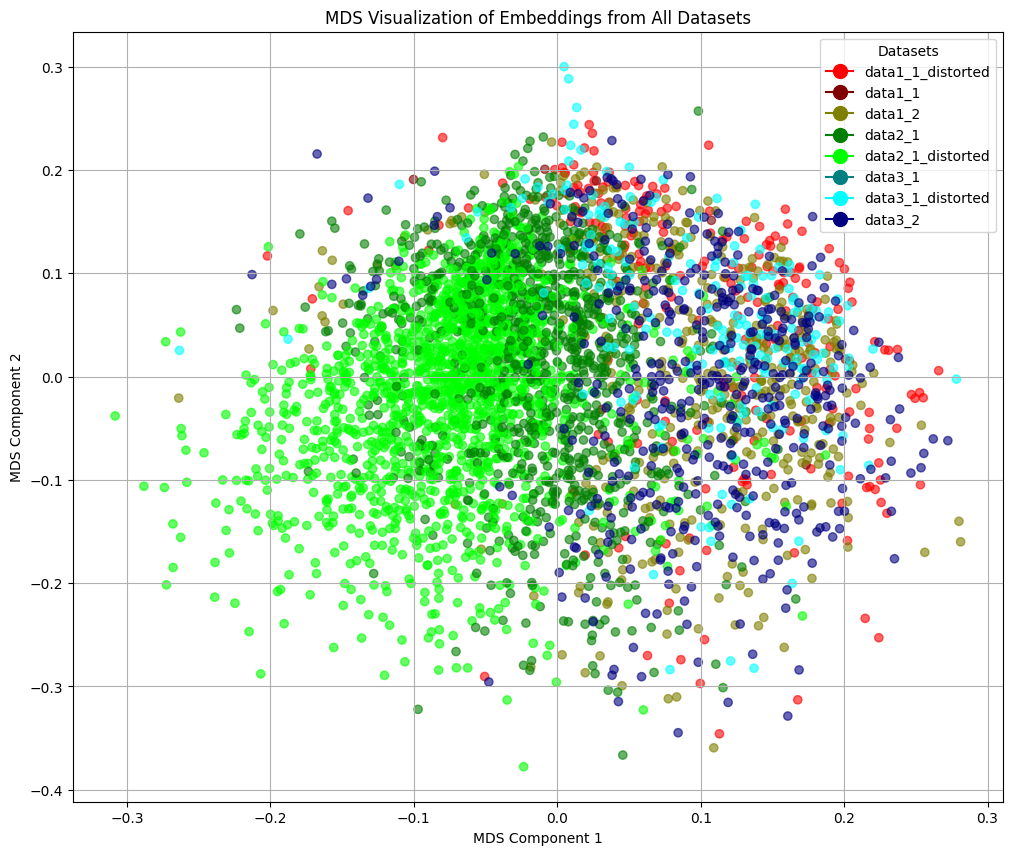

In [ ]:
# All cases
# Get the original dataset indices for coloring
data1_1_len = len(data1_1_encoded)
data1_2_len = len(data1_2_encoded)
data2_1_len = len(data2_1_encoded)
data3_1_len = len(data3_1_encoded)
data3_2_len = len(data3_2_encoded)

dataset_indices = []
dataset_indices += [(0.5*x+0.5, 0, 0) for x in data1_1_labels] # data1_1
dataset_indices += [(0.5, 0.5, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, 0.5*x+0.5, 0) for x in data2_1_labels] # data2_1
dataset_indices += [(0, 0.5*x+0.5, 0.5*x+0.5) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 0.5) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(1, 0, 0), label='data1_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0.5, 0, 0), label='data1_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0.5, 0.5, 0), label='data1_2', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0.5, 0), label='data2_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 0), label='data2_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0.5, 0.5), label='data3_1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 1), label='data3_1_distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 0.5), label='data3_2', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

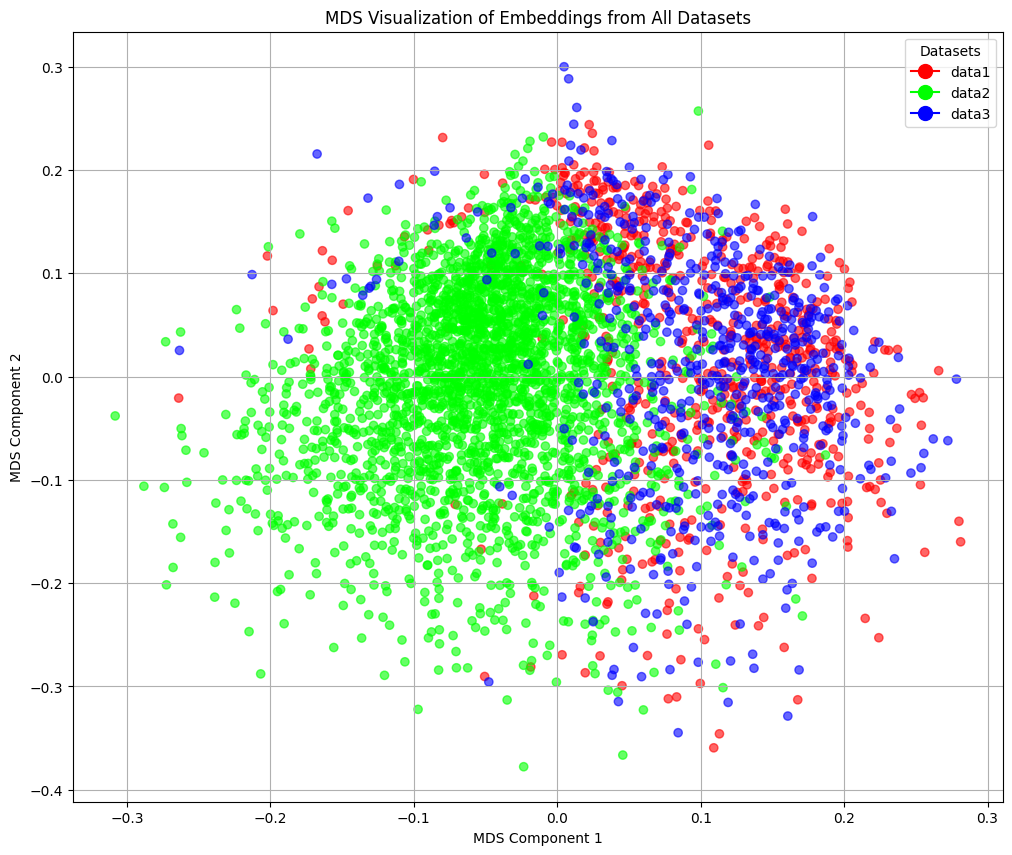

In [ ]:
# Comparing data - source
# Get the original dataset indices for coloring
dataset_indices = []
dataset_indices += [(1, 0, 0) for x in data1_1_labels] # data1_1
dataset_indices += [(1, 0, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, 1, 0) for x in data2_1_labels] # data2_1
dataset_indices += [(0, 0, 1) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 1) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(1, 0, 0), label='data1', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 1, 0), label='data2', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 1), label='data3', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

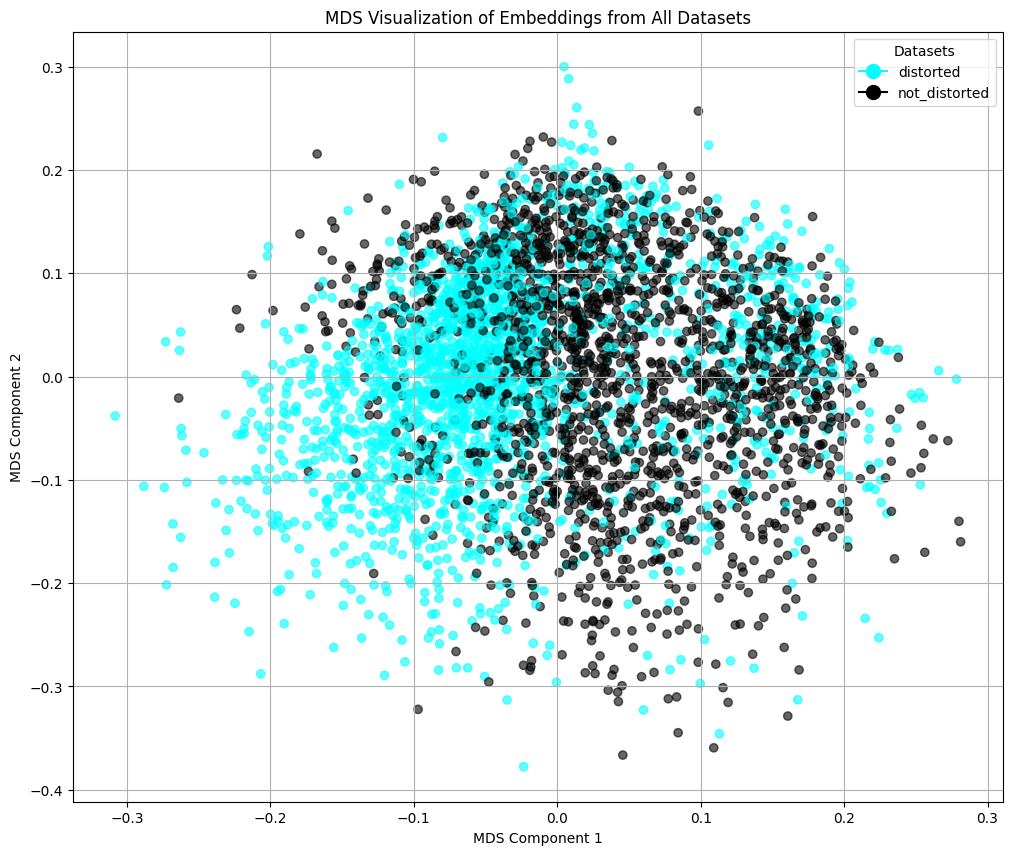

In [ ]:
# Comparing data - distortedness
# Get the original dataset indices for coloring
data1_1_len = len(data1_1_encoded)
data1_2_len = len(data1_2_encoded)
data2_1_len = len(data2_1_encoded)
data3_1_len = len(data3_1_encoded)
data3_2_len = len(data3_2_encoded)

dataset_indices = []
dataset_indices += [(0, x, x) for x in data1_1_labels] # data1_1
dataset_indices += [(0, 0, 0) for x in data1_2_labels] # data1_2
dataset_indices += [(0, x, x) for x in data2_1_labels] # data2_1
dataset_indices += [(0, x, x) for x in data3_1_labels] # data3_1
dataset_indices += [(0, 0, 0) for x in data3_2_labels] # data3_2

# Visualize the results with different colors for each dataset
plt.figure(figsize=(12, 10))
scatter = plt.scatter(mds_result[:, 0], mds_result[:, 1], color=dataset_indices, alpha=0.6)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=(0, 1, 1), label='distorted', markersize=10),
                   plt.Line2D([0], [0], marker='o', color=(0, 0, 0), label='not_distorted', markersize=10)]

plt.legend(handles=legend_elements, title="Datasets")

plt.title('MDS Visualization of Embeddings from All Datasets')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

#### 4-1-2. 잠재 벡터

In [18]:
# latent vector
print(model.label_emb)

Parameter containing:
tensor([[-1.4421,  0.3604,  0.7556,  ..., -0.4580, -2.2978, -0.8544],
        [-1.6524, -0.8122,  1.2399,  ..., -0.9437,  0.7409, -0.5597]],
       device='cuda:0', requires_grad=True)


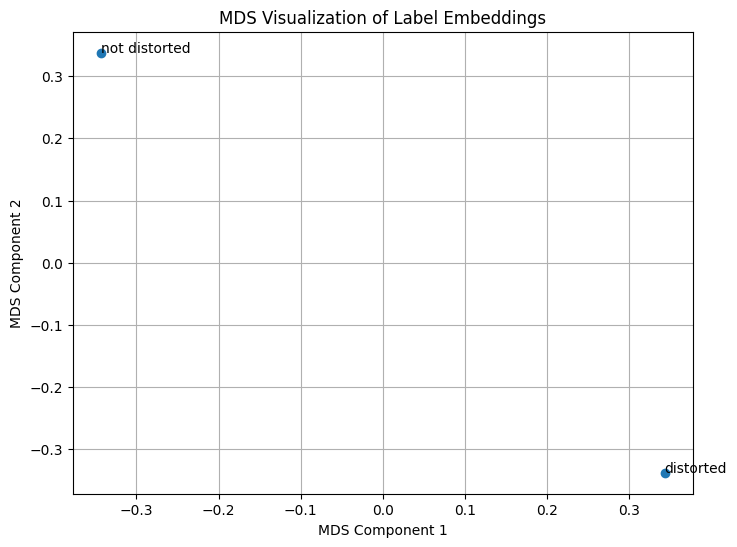

In [21]:
# Get the label embeddings
label_embeddings = model.label_emb.detach().cpu().numpy()

# Compute similarity and distance matrices
similarity_matrix_labels = cosine_similarity(label_embeddings)
distance_matrix_labels = 1 - similarity_matrix_labels

# Perform MDS on label embeddings
mds_labels = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
mds_result_labels = mds_labels.fit_transform(distance_matrix_labels)

# Get the labels for plotting (0 and 1 in this case)
labels_for_plot = list(range(len(label_embeddings)))

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(mds_result_labels[:, 0], mds_result_labels[:, 1])

# Annotate points with labels
labelled=['not distorted', 'distorted']
for i, label in enumerate(labels_for_plot):
    plt.text(mds_result_labels[i, 0], mds_result_labels[i, 1], labelled[label])

plt.title('MDS Visualization of Label Embeddings')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()

## 5. 데이터셋 분류 모델

### 5-1. 모델 정보

In [ ]:
# Add labels
data1_1_m_labels = [0 for i in range(len(data1_1_encoded))]
data2_1_m_labels = [1 for i in range(len(data2_1_encoded))]
data3_1_m_labels = [2 for i in range(len(data3_1_encoded))]

data1_2_m_labels = [0 for i in range(len(data1_2_encoded))]
data3_2_m_labels = [2 for i in range(len(data3_2_encoded))]

In [ ]:
data_m_labels = data1_1_m_labels + data1_2_m_labels + data2_1_m_labels + data3_1_m_labels + data3_2_m_labels

In [ ]:
m_dataset_with_labels = CustomDatasetWithLabels(data_encoded, data_m_labels)

# Define proportions for splitting
m_train_size = int(0.8 * len(m_dataset_with_labels))
m_val_size = int(0.1 * len(m_dataset_with_labels))
m_test_size = len(m_dataset_with_labels) - m_train_size - m_val_size

# Split the dataset
m_train_dataset, m_val_dataset, m_test_dataset = random_split(m_dataset_with_labels, [m_train_size, m_val_size, m_test_size])

# Create DataLoaders for each set
m_train_dataloader = DataLoader(m_train_dataset, batch_size=64, shuffle=True)
m_val_dataloader = DataLoader(m_val_dataset, batch_size=64)
m_test_dataloader = DataLoader(m_test_dataset, batch_size=64)

m_num_labels = len(set(data_m_labels))
m_label_emb = torch.randn(m_num_labels, input_dim)

### 5-2. 모델 생성

In [ ]:
# Instantiate the InnerProductClassifier model
m_model = InnerProductClassifier(input_dim, m_label_emb).to(device)

# Define optimizer
optimizer = torch.optim.AdamW(m_model.parameters(), lr=2e-4)

### 5-3. 모델 학습

In [ ]:
m_EPOCHS=5

for epoch in range(m_EPOCHS):
    m_model.train()
    for batch in tqdm(m_train_dataloader, desc=f"Epoch {epoch}"):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["y"].to(device)

        # Get embeddings from the BERT model
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :] # Get the [CLS] token embedding

        # Pass embeddings to the InnerProductClassifier
        logits = m_model(embeddings)
        loss = criterion(logits, y)

        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

    # Evaluate on the validation set after each epoch
    m_val_metrics = evaluate(m_model, m_val_dataloader, device)
    print(f"Epoch {epoch} Validation Accuracy: {m_val_metrics['accuracy']}, F1-macro: {m_val_metrics['f1_macro']}")

Epoch 0:   2%|▏         | 1/49 [00:01<01:30,  1.88s/it]

Loss: 11.183639526367188


Epoch 0:   4%|▍         | 2/49 [00:03<01:28,  1.89s/it]

Loss: 5.424675464630127


Epoch 0:   6%|▌         | 3/49 [00:05<01:26,  1.89s/it]

Loss: 4.864298343658447


Epoch 0:   8%|▊         | 4/49 [00:07<01:25,  1.90s/it]

Loss: 6.96069860458374


Epoch 0:  10%|█         | 5/49 [00:09<01:23,  1.90s/it]

Loss: 6.889959335327148


Epoch 0:  12%|█▏        | 6/49 [00:11<01:22,  1.91s/it]

Loss: 7.2405195236206055


Epoch 0:  14%|█▍        | 7/49 [00:13<01:20,  1.92s/it]

Loss: 6.090959548950195


Epoch 0:  16%|█▋        | 8/49 [00:15<01:18,  1.92s/it]

Loss: 6.325288772583008


Epoch 0:  18%|█▊        | 9/49 [00:17<01:17,  1.93s/it]

Loss: 2.4802393913269043


Epoch 0:  20%|██        | 10/49 [00:19<01:15,  1.94s/it]

Loss: 1.204761028289795


Epoch 0:  22%|██▏       | 11/49 [00:21<01:13,  1.94s/it]

Loss: 1.387978196144104


Epoch 0:  24%|██▍       | 12/49 [00:23<01:11,  1.94s/it]

Loss: 1.9875948429107666


Epoch 0:  27%|██▋       | 13/49 [00:24<01:09,  1.94s/it]

Loss: 5.082529067993164


Epoch 0:  29%|██▊       | 14/49 [00:26<01:07,  1.93s/it]

Loss: 5.468249320983887


Epoch 0:  31%|███       | 15/49 [00:28<01:05,  1.92s/it]

Loss: 2.5846283435821533


Epoch 0:  33%|███▎      | 16/49 [00:30<01:03,  1.91s/it]

Loss: 1.703332781791687


Epoch 0:  35%|███▍      | 17/49 [00:32<01:01,  1.91s/it]

Loss: 0.7150688171386719


Epoch 0:  37%|███▋      | 18/49 [00:34<00:58,  1.90s/it]

Loss: 2.3134312629699707


Epoch 0:  39%|███▉      | 19/49 [00:36<00:56,  1.89s/it]

Loss: 3.2791390419006348


Epoch 0:  41%|████      | 20/49 [00:38<00:54,  1.88s/it]

Loss: 2.249511957168579


Epoch 0:  43%|████▎     | 21/49 [00:40<00:52,  1.87s/it]

Loss: 2.1097869873046875


Epoch 0:  45%|████▍     | 22/49 [00:41<00:50,  1.87s/it]

Loss: 1.0778435468673706


Epoch 0:  47%|████▋     | 23/49 [00:43<00:48,  1.86s/it]

Loss: 1.8943933248519897


Epoch 0:  49%|████▉     | 24/49 [00:45<00:46,  1.85s/it]

Loss: 1.0905228853225708


Epoch 0:  51%|█████     | 25/49 [00:47<00:44,  1.85s/it]

Loss: 0.7947913408279419


Epoch 0:  53%|█████▎    | 26/49 [00:49<00:42,  1.84s/it]

Loss: 1.0846117734909058


Epoch 0:  55%|█████▌    | 27/49 [00:51<00:40,  1.84s/it]

Loss: 0.21804891526699066


Epoch 0:  57%|█████▋    | 28/49 [00:52<00:38,  1.83s/it]

Loss: 1.966877818107605


Epoch 0:  59%|█████▉    | 29/49 [00:54<00:36,  1.83s/it]

Loss: 0.7779546976089478


Epoch 0:  61%|██████    | 30/49 [00:56<00:34,  1.83s/it]

Loss: 0.8241891860961914


Epoch 0:  63%|██████▎   | 31/49 [00:58<00:32,  1.83s/it]

Loss: 1.7274930477142334


Epoch 0:  65%|██████▌   | 32/49 [01:00<00:31,  1.82s/it]

Loss: 1.7648873329162598


Epoch 0:  67%|██████▋   | 33/49 [01:02<00:29,  1.82s/it]

Loss: 0.6122632026672363


Epoch 0:  69%|██████▉   | 34/49 [01:03<00:27,  1.82s/it]

Loss: 0.7682023048400879


Epoch 0:  71%|███████▏  | 35/49 [01:05<00:25,  1.82s/it]

Loss: 0.6826866865158081


Epoch 0:  73%|███████▎  | 36/49 [01:07<00:23,  1.82s/it]

Loss: 1.0443683862686157


Epoch 0:  76%|███████▌  | 37/49 [01:09<00:21,  1.82s/it]

Loss: 0.613091766834259


Epoch 0:  78%|███████▊  | 38/49 [01:11<00:20,  1.82s/it]

Loss: 0.7493301630020142


Epoch 0:  80%|███████▉  | 39/49 [01:12<00:18,  1.82s/it]

Loss: 0.7055964469909668


Epoch 0:  82%|████████▏ | 40/49 [01:14<00:16,  1.82s/it]

Loss: 0.2269885092973709


Epoch 0:  84%|████████▎ | 41/49 [01:16<00:14,  1.83s/it]

Loss: 0.7036494612693787


Epoch 0:  86%|████████▌ | 42/49 [01:18<00:12,  1.83s/it]

Loss: 0.7730884552001953


Epoch 0:  88%|████████▊ | 43/49 [01:20<00:10,  1.83s/it]

Loss: 0.5843947529792786


Epoch 0:  90%|████████▉ | 44/49 [01:22<00:09,  1.84s/it]

Loss: 0.21899646520614624


Epoch 0:  92%|█████████▏| 45/49 [01:23<00:07,  1.84s/it]

Loss: 0.28960755467414856


Epoch 0:  94%|█████████▍| 46/49 [01:25<00:05,  1.84s/it]

Loss: 0.33669334650039673


Epoch 0:  96%|█████████▌| 47/49 [01:27<00:03,  1.84s/it]

Loss: 0.4645695686340332


Epoch 0:  98%|█████████▊| 48/49 [01:29<00:01,  1.85s/it]

Loss: 0.47353366017341614


Epoch 0: 100%|██████████| 49/49 [01:30<00:00,  1.84s/it]

Loss: 1.5229113101959229


Epoch 0 Validation Accuracy: 0.8937823834196891, F1-macro: 0.8205801768572979


Epoch 1:   2%|▏         | 1/49 [00:01<01:29,  1.86s/it]

Loss: 0.7517758011817932


Epoch 1:   4%|▍         | 2/49 [00:03<01:27,  1.86s/it]

Loss: 0.9878469109535217


Epoch 1:   6%|▌         | 3/49 [00:05<01:25,  1.87s/it]

Loss: 0.5820605158805847


Epoch 1:   8%|▊         | 4/49 [00:07<01:24,  1.87s/it]

Loss: 0.2851905822753906


Epoch 1:  10%|█         | 5/49 [00:09<01:22,  1.87s/it]

Loss: 1.4041225910186768


Epoch 1:  12%|█▏        | 6/49 [00:11<01:20,  1.87s/it]

Loss: 0.25718361139297485


Epoch 1:  14%|█▍        | 7/49 [00:13<01:18,  1.87s/it]

Loss: 0.21973900496959686


Epoch 1:  16%|█▋        | 8/49 [00:14<01:16,  1.87s/it]

Loss: 0.7025353908538818


Epoch 1:  18%|█▊        | 9/49 [00:16<01:14,  1.87s/it]

Loss: 0.3751924932003021


Epoch 1:  20%|██        | 10/49 [00:18<01:12,  1.87s/it]

Loss: 0.6436510682106018


Epoch 1:  22%|██▏       | 11/49 [00:20<01:10,  1.87s/it]

Loss: 0.2931610941886902


Epoch 1:  24%|██▍       | 12/49 [00:22<01:09,  1.87s/it]

Loss: 0.44407355785369873


Epoch 1:  27%|██▋       | 13/49 [00:24<01:07,  1.86s/it]

Loss: 0.3193221688270569


Epoch 1:  29%|██▊       | 14/49 [00:26<01:05,  1.86s/it]

Loss: 0.29443997144699097


Epoch 1:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 0.39601314067840576


Epoch 1:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 0.6571241617202759


Epoch 1:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.6577935218811035


Epoch 1:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 0.6422933340072632


Epoch 1:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.459886372089386


Epoch 1:  41%|████      | 20/49 [00:37<00:53,  1.86s/it]

Loss: 0.11796154081821442


Epoch 1:  43%|████▎     | 21/49 [00:39<00:51,  1.85s/it]

Loss: 0.4511677026748657


Epoch 1:  45%|████▍     | 22/49 [00:40<00:50,  1.85s/it]

Loss: 0.4090321362018585


Epoch 1:  47%|████▋     | 23/49 [00:42<00:48,  1.85s/it]

Loss: 0.2616868317127228


Epoch 1:  49%|████▉     | 24/49 [00:44<00:46,  1.85s/it]

Loss: 0.4790017306804657


Epoch 1:  51%|█████     | 25/49 [00:46<00:44,  1.85s/it]

Loss: 0.5741052627563477


Epoch 1:  53%|█████▎    | 26/49 [00:48<00:42,  1.85s/it]

Loss: 0.3482169508934021


Epoch 1:  55%|█████▌    | 27/49 [00:50<00:40,  1.85s/it]

Loss: 0.6986142992973328


Epoch 1:  57%|█████▋    | 28/49 [00:52<00:38,  1.85s/it]

Loss: 0.38724029064178467


Epoch 1:  59%|█████▉    | 29/49 [00:53<00:36,  1.85s/it]

Loss: 0.47865229845046997


Epoch 1:  61%|██████    | 30/49 [00:55<00:35,  1.85s/it]

Loss: 0.7278589010238647


Epoch 1:  63%|██████▎   | 31/49 [00:57<00:33,  1.85s/it]

Loss: 0.38049137592315674


Epoch 1:  65%|██████▌   | 32/49 [00:59<00:31,  1.85s/it]

Loss: 0.4026808440685272


Epoch 1:  67%|██████▋   | 33/49 [01:01<00:29,  1.85s/it]

Loss: 0.6800563931465149


Epoch 1:  69%|██████▉   | 34/49 [01:03<00:27,  1.84s/it]

Loss: 0.7394756078720093


Epoch 1:  71%|███████▏  | 35/49 [01:04<00:25,  1.84s/it]

Loss: 0.2025614082813263


Epoch 1:  73%|███████▎  | 36/49 [01:06<00:23,  1.84s/it]

Loss: 0.3669680655002594


Epoch 1:  76%|███████▌  | 37/49 [01:08<00:22,  1.84s/it]

Loss: 0.2900008261203766


Epoch 1:  78%|███████▊  | 38/49 [01:10<00:20,  1.84s/it]

Loss: 0.5049028396606445


Epoch 1:  80%|███████▉  | 39/49 [01:12<00:18,  1.84s/it]

Loss: 0.41347450017929077


Epoch 1:  82%|████████▏ | 40/49 [01:14<00:16,  1.84s/it]

Loss: 0.1650119125843048


Epoch 1:  84%|████████▎ | 41/49 [01:16<00:14,  1.84s/it]

Loss: 0.28050705790519714


Epoch 1:  86%|████████▌ | 42/49 [01:17<00:12,  1.84s/it]

Loss: 0.0714038833975792


Epoch 1:  88%|████████▊ | 43/49 [01:19<00:11,  1.84s/it]

Loss: 0.9974185228347778


Epoch 1:  90%|████████▉ | 44/49 [01:21<00:09,  1.84s/it]

Loss: 0.4515368938446045


Epoch 1:  92%|█████████▏| 45/49 [01:23<00:07,  1.85s/it]

Loss: 0.7537548542022705


Epoch 1:  94%|█████████▍| 46/49 [01:25<00:05,  1.85s/it]

Loss: 0.8336681127548218


Epoch 1:  96%|█████████▌| 47/49 [01:27<00:03,  1.85s/it]

Loss: 0.3473012149333954


Epoch 1:  98%|█████████▊| 48/49 [01:28<00:01,  1.85s/it]

Loss: 0.5334755182266235


Epoch 1: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.8689647316932678


Epoch 1 Validation Accuracy: 0.8989637305699482, F1-macro: 0.8313105073172067


Epoch 2:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.432331919670105


Epoch 2:   4%|▍         | 2/49 [00:03<01:26,  1.85s/it]

Loss: 0.33930930495262146


Epoch 2:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 0.21703021228313446


Epoch 2:   8%|▊         | 4/49 [00:07<01:23,  1.86s/it]

Loss: 0.12015461176633835


Epoch 2:  10%|█         | 5/49 [00:09<01:21,  1.86s/it]

Loss: 0.38212835788726807


Epoch 2:  12%|█▏        | 6/49 [00:11<01:19,  1.86s/it]

Loss: 0.30382806062698364


Epoch 2:  14%|█▍        | 7/49 [00:13<01:18,  1.86s/it]

Loss: 0.2556305527687073


Epoch 2:  16%|█▋        | 8/49 [00:14<01:16,  1.86s/it]

Loss: 0.7197574377059937


Epoch 2:  18%|█▊        | 9/49 [00:16<01:14,  1.86s/it]

Loss: 0.194789320230484


Epoch 2:  20%|██        | 10/49 [00:18<01:12,  1.86s/it]

Loss: 0.5869482755661011


Epoch 2:  22%|██▏       | 11/49 [00:20<01:10,  1.86s/it]

Loss: 0.25906816124916077


Epoch 2:  24%|██▍       | 12/49 [00:22<01:08,  1.86s/it]

Loss: 0.12445232272148132


Epoch 2:  27%|██▋       | 13/49 [00:24<01:06,  1.86s/it]

Loss: 0.39820319414138794


Epoch 2:  29%|██▊       | 14/49 [00:26<01:05,  1.86s/it]

Loss: 0.34811994433403015


Epoch 2:  31%|███       | 15/49 [00:27<01:03,  1.86s/it]

Loss: 0.4724210202693939


Epoch 2:  33%|███▎      | 16/49 [00:29<01:01,  1.86s/it]

Loss: 0.09410924464464188


Epoch 2:  35%|███▍      | 17/49 [00:31<00:59,  1.86s/it]

Loss: 0.3477591872215271


Epoch 2:  37%|███▋      | 18/49 [00:33<00:57,  1.86s/it]

Loss: 0.28913772106170654


Epoch 2:  39%|███▉      | 19/49 [00:35<00:55,  1.86s/it]

Loss: 0.3307743966579437


Epoch 2:  41%|████      | 20/49 [00:37<00:53,  1.86s/it]

Loss: 0.4139249920845032


Epoch 2:  43%|████▎     | 21/49 [00:39<00:52,  1.86s/it]

Loss: 0.16881218552589417


Epoch 2:  45%|████▍     | 22/49 [00:40<00:50,  1.86s/it]

Loss: 0.21861819922924042


Epoch 2:  47%|████▋     | 23/49 [00:42<00:48,  1.86s/it]

Loss: 0.22689364850521088


Epoch 2:  49%|████▉     | 24/49 [00:44<00:46,  1.86s/it]

Loss: 0.43045133352279663


Epoch 2:  51%|█████     | 25/49 [00:46<00:44,  1.86s/it]

Loss: 0.5977412462234497


Epoch 2:  53%|█████▎    | 26/49 [00:48<00:42,  1.86s/it]

Loss: 0.5021082758903503


Epoch 2:  55%|█████▌    | 27/49 [00:50<00:40,  1.86s/it]

Loss: 0.30899032950401306


Epoch 2:  57%|█████▋    | 28/49 [00:52<00:39,  1.86s/it]

Loss: 0.2501869201660156


Epoch 2:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 0.24172471463680267


Epoch 2:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 0.6526866555213928


Epoch 2:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.13595329225063324


Epoch 2:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.1582433134317398


Epoch 2:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.11355607956647873


Epoch 2:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.5693337917327881


Epoch 2:  71%|███████▏  | 35/49 [01:05<00:25,  1.85s/it]

Loss: 0.31988734006881714


Epoch 2:  73%|███████▎  | 36/49 [01:06<00:24,  1.85s/it]

Loss: 0.18393707275390625


Epoch 2:  76%|███████▌  | 37/49 [01:08<00:22,  1.85s/it]

Loss: 0.35524848103523254


Epoch 2:  78%|███████▊  | 38/49 [01:10<00:20,  1.85s/it]

Loss: 0.23553374409675598


Epoch 2:  80%|███████▉  | 39/49 [01:12<00:18,  1.85s/it]

Loss: 0.11938349902629852


Epoch 2:  82%|████████▏ | 40/49 [01:14<00:16,  1.85s/it]

Loss: 0.38433223962783813


Epoch 2:  84%|████████▎ | 41/49 [01:16<00:14,  1.85s/it]

Loss: 0.16181959211826324


Epoch 2:  86%|████████▌ | 42/49 [01:18<00:12,  1.85s/it]

Loss: 0.1413571983575821


Epoch 2:  88%|████████▊ | 43/49 [01:19<00:11,  1.85s/it]

Loss: 0.5042777061462402


Epoch 2:  90%|████████▉ | 44/49 [01:21<00:09,  1.85s/it]

Loss: 0.18810449540615082


Epoch 2:  92%|█████████▏| 45/49 [01:23<00:07,  1.85s/it]

Loss: 0.7224522829055786


Epoch 2:  94%|█████████▍| 46/49 [01:25<00:05,  1.85s/it]

Loss: 0.02953711524605751


Epoch 2:  96%|█████████▌| 47/49 [01:27<00:03,  1.85s/it]

Loss: 0.4002586603164673


Epoch 2:  98%|█████████▊| 48/49 [01:29<00:01,  1.85s/it]

Loss: 0.31350645422935486


Epoch 2: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.44925573468208313


Epoch 2 Validation Accuracy: 0.8808290155440415, F1-macro: 0.8047747055811572


Epoch 3:   2%|▏         | 1/49 [00:01<01:28,  1.85s/it]

Loss: 0.48298436403274536


Epoch 3:   4%|▍         | 2/49 [00:03<01:26,  1.85s/it]

Loss: 0.5603077411651611


Epoch 3:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 1.0075697898864746


Epoch 3:   8%|▊         | 4/49 [00:07<01:23,  1.85s/it]

Loss: 0.9884892106056213


Epoch 3:  10%|█         | 5/49 [00:09<01:21,  1.85s/it]

Loss: 0.7215105295181274


Epoch 3:  12%|█▏        | 6/49 [00:11<01:19,  1.85s/it]

Loss: 0.7592127323150635


Epoch 3:  14%|█▍        | 7/49 [00:12<01:17,  1.85s/it]

Loss: 1.6470038890838623


Epoch 3:  16%|█▋        | 8/49 [00:14<01:15,  1.85s/it]

Loss: 1.4352821111679077


Epoch 3:  18%|█▊        | 9/49 [00:16<01:14,  1.85s/it]

Loss: 0.4097539484500885


Epoch 3:  20%|██        | 10/49 [00:18<01:12,  1.85s/it]

Loss: 0.6565747261047363


Epoch 3:  22%|██▏       | 11/49 [00:20<01:10,  1.85s/it]

Loss: 2.212963819503784


Epoch 3:  24%|██▍       | 12/49 [00:22<01:08,  1.85s/it]

Loss: 1.0184766054153442


Epoch 3:  27%|██▋       | 13/49 [00:24<01:06,  1.85s/it]

Loss: 0.9219315052032471


Epoch 3:  29%|██▊       | 14/49 [00:25<01:04,  1.85s/it]

Loss: 0.1740679144859314


Epoch 3:  31%|███       | 15/49 [00:27<01:02,  1.85s/it]

Loss: 0.5212047100067139


Epoch 3:  33%|███▎      | 16/49 [00:29<01:01,  1.85s/it]

Loss: 0.8210700154304504


Epoch 3:  35%|███▍      | 17/49 [00:31<00:59,  1.85s/it]

Loss: 0.43668848276138306


Epoch 3:  37%|███▋      | 18/49 [00:33<00:57,  1.85s/it]

Loss: 0.4838710427284241


Epoch 3:  39%|███▉      | 19/49 [00:35<00:55,  1.85s/it]

Loss: 0.08351403474807739


Epoch 3:  41%|████      | 20/49 [00:37<00:53,  1.85s/it]

Loss: 0.20933863520622253


Epoch 3:  43%|████▎     | 21/49 [00:38<00:51,  1.85s/it]

Loss: 0.4121757447719574


Epoch 3:  45%|████▍     | 22/49 [00:40<00:49,  1.85s/it]

Loss: 0.2713404893875122


Epoch 3:  47%|████▋     | 23/49 [00:42<00:48,  1.85s/it]

Loss: 0.27563756704330444


Epoch 3:  49%|████▉     | 24/49 [00:44<00:46,  1.85s/it]

Loss: 0.3328845500946045


Epoch 3:  51%|█████     | 25/49 [00:46<00:44,  1.85s/it]

Loss: 0.1609487533569336


Epoch 3:  53%|█████▎    | 26/49 [00:48<00:42,  1.85s/it]

Loss: 0.3018431067466736


Epoch 3:  55%|█████▌    | 27/49 [00:49<00:40,  1.85s/it]

Loss: 0.36995917558670044


Epoch 3:  57%|█████▋    | 28/49 [00:51<00:38,  1.85s/it]

Loss: 0.18058030307292938


Epoch 3:  59%|█████▉    | 29/49 [00:53<00:36,  1.85s/it]

Loss: 0.3761591911315918


Epoch 3:  61%|██████    | 30/49 [00:55<00:35,  1.85s/it]

Loss: 0.2086896002292633


Epoch 3:  63%|██████▎   | 31/49 [00:57<00:33,  1.85s/it]

Loss: 0.3468720316886902


Epoch 3:  65%|██████▌   | 32/49 [00:59<00:31,  1.85s/it]

Loss: 0.33397647738456726


Epoch 3:  67%|██████▋   | 33/49 [01:01<00:29,  1.85s/it]

Loss: 0.2829327881336212


Epoch 3:  69%|██████▉   | 34/49 [01:02<00:27,  1.85s/it]

Loss: 0.040889181196689606


Epoch 3:  71%|███████▏  | 35/49 [01:04<00:25,  1.85s/it]

Loss: 0.11927266418933868


Epoch 3:  73%|███████▎  | 36/49 [01:06<00:24,  1.85s/it]

Loss: 0.329091340303421


Epoch 3:  76%|███████▌  | 37/49 [01:08<00:22,  1.85s/it]

Loss: 0.054919760674238205


Epoch 3:  78%|███████▊  | 38/49 [01:10<00:20,  1.85s/it]

Loss: 0.13756917417049408


Epoch 3:  80%|███████▉  | 39/49 [01:12<00:18,  1.85s/it]

Loss: 0.2053937315940857


Epoch 3:  82%|████████▏ | 40/49 [01:13<00:16,  1.85s/it]

Loss: 0.20830778777599335


Epoch 3:  84%|████████▎ | 41/49 [01:15<00:14,  1.85s/it]

Loss: 0.2992773652076721


Epoch 3:  86%|████████▌ | 42/49 [01:17<00:12,  1.85s/it]

Loss: 0.3239392042160034


Epoch 3:  88%|████████▊ | 43/49 [01:19<00:11,  1.85s/it]

Loss: 0.05914758890867233


Epoch 3:  90%|████████▉ | 44/49 [01:21<00:09,  1.85s/it]

Loss: 0.3035532236099243


Epoch 3:  92%|█████████▏| 45/49 [01:23<00:07,  1.85s/it]

Loss: 0.27673354744911194


Epoch 3:  94%|█████████▍| 46/49 [01:25<00:05,  1.85s/it]

Loss: 0.1450670063495636


Epoch 3:  96%|█████████▌| 47/49 [01:26<00:03,  1.85s/it]

Loss: 0.16556034982204437


Epoch 3:  98%|█████████▊| 48/49 [01:28<00:01,  1.85s/it]

Loss: 0.14140594005584717


Epoch 3: 100%|██████████| 49/49 [01:29<00:00,  1.82s/it]

Loss: 0.6127285361289978


Epoch 3 Validation Accuracy: 0.8808290155440415, F1-macro: 0.7791503566211871


Epoch 4:   2%|▏         | 1/49 [00:01<01:28,  1.84s/it]

Loss: 0.6169774532318115


Epoch 4:   4%|▍         | 2/49 [00:03<01:26,  1.85s/it]

Loss: 0.3468291163444519


Epoch 4:   6%|▌         | 3/49 [00:05<01:25,  1.85s/it]

Loss: 0.5768626928329468


Epoch 4:   8%|▊         | 4/49 [00:07<01:23,  1.85s/it]

Loss: 0.1523585021495819


Epoch 4:  10%|█         | 5/49 [00:09<01:21,  1.85s/it]

Loss: 0.16074968874454498


Epoch 4:  12%|█▏        | 6/49 [00:11<01:19,  1.85s/it]

Loss: 0.3687470555305481


Epoch 4:  14%|█▍        | 7/49 [00:12<01:17,  1.85s/it]

Loss: 0.18230167031288147


Epoch 4:  16%|█▋        | 8/49 [00:14<01:15,  1.85s/it]

Loss: 0.13301192224025726


Epoch 4:  18%|█▊        | 9/49 [00:16<01:14,  1.85s/it]

Loss: 0.40199148654937744


Epoch 4:  20%|██        | 10/49 [00:18<01:12,  1.85s/it]

Loss: 0.12828072905540466


Epoch 4:  22%|██▏       | 11/49 [00:20<01:10,  1.85s/it]

Loss: 0.10773593932390213


Epoch 4:  24%|██▍       | 12/49 [00:22<01:08,  1.85s/it]

Loss: 0.09923206269741058


Epoch 4:  27%|██▋       | 13/49 [00:24<01:06,  1.85s/it]

Loss: 0.1455969214439392


Epoch 4:  29%|██▊       | 14/49 [00:25<01:04,  1.85s/it]

Loss: 0.48993590474128723


Epoch 4:  31%|███       | 15/49 [00:27<01:03,  1.85s/it]

Loss: 0.15261012315750122


Epoch 4:  33%|███▎      | 16/49 [00:29<01:01,  1.85s/it]

Loss: 0.2948821485042572


Epoch 4:  35%|███▍      | 17/49 [00:31<00:59,  1.85s/it]

Loss: 0.2734246253967285


Epoch 4:  37%|███▋      | 18/49 [00:33<00:57,  1.85s/it]

Loss: 0.05240761116147041


Epoch 4:  39%|███▉      | 19/49 [00:35<00:55,  1.85s/it]

Loss: 0.1786334216594696


Epoch 4:  41%|████      | 20/49 [00:37<00:53,  1.85s/it]

Loss: 0.25826260447502136


Epoch 4:  43%|████▎     | 21/49 [00:38<00:51,  1.85s/it]

Loss: 0.05361181125044823


Epoch 4:  45%|████▍     | 22/49 [00:40<00:50,  1.85s/it]

Loss: 0.19214829802513123


Epoch 4:  47%|████▋     | 23/49 [00:42<00:48,  1.85s/it]

Loss: 0.30779799818992615


Epoch 4:  49%|████▉     | 24/49 [00:44<00:46,  1.85s/it]

Loss: 0.24447855353355408


Epoch 4:  51%|█████     | 25/49 [00:46<00:44,  1.85s/it]

Loss: 0.2121049463748932


Epoch 4:  53%|█████▎    | 26/49 [00:48<00:42,  1.85s/it]

Loss: 0.04447469487786293


Epoch 4:  55%|█████▌    | 27/49 [00:50<00:40,  1.85s/it]

Loss: 0.27600663900375366


Epoch 4:  57%|█████▋    | 28/49 [00:51<00:38,  1.85s/it]

Loss: 0.06359976530075073


Epoch 4:  59%|█████▉    | 29/49 [00:53<00:37,  1.86s/it]

Loss: 0.08336104452610016


Epoch 4:  61%|██████    | 30/49 [00:55<00:35,  1.86s/it]

Loss: 0.5322011709213257


Epoch 4:  63%|██████▎   | 31/49 [00:57<00:33,  1.86s/it]

Loss: 0.0352204404771328


Epoch 4:  65%|██████▌   | 32/49 [00:59<00:31,  1.86s/it]

Loss: 0.030512280762195587


Epoch 4:  67%|██████▋   | 33/49 [01:01<00:29,  1.86s/it]

Loss: 0.2916048467159271


Epoch 4:  69%|██████▉   | 34/49 [01:03<00:27,  1.86s/it]

Loss: 0.23886805772781372


Epoch 4:  71%|███████▏  | 35/49 [01:04<00:25,  1.86s/it]

Loss: 0.18107345700263977


Epoch 4:  73%|███████▎  | 36/49 [01:06<00:24,  1.86s/it]

Loss: 0.43830156326293945


Epoch 4:  76%|███████▌  | 37/49 [01:08<00:22,  1.86s/it]

Loss: 0.09078621864318848


Epoch 4:  78%|███████▊  | 38/49 [01:10<00:20,  1.86s/it]

Loss: 0.3097989559173584


Epoch 4:  80%|███████▉  | 39/49 [01:12<00:18,  1.86s/it]

Loss: 0.06532689183950424


Epoch 4:  82%|████████▏ | 40/49 [01:14<00:16,  1.86s/it]

Loss: 0.12797662615776062


Epoch 4:  84%|████████▎ | 41/49 [01:16<00:14,  1.86s/it]

Loss: 0.14605583250522614


Epoch 4:  86%|████████▌ | 42/49 [01:17<00:12,  1.86s/it]

Loss: 0.2167682945728302


Epoch 4:  88%|████████▊ | 43/49 [01:19<00:11,  1.86s/it]

Loss: 0.30810391902923584


Epoch 4:  90%|████████▉ | 44/49 [01:21<00:09,  1.86s/it]

Loss: 0.40915077924728394


Epoch 4:  92%|█████████▏| 45/49 [01:23<00:07,  1.86s/it]

Loss: 0.5522823333740234


Epoch 4:  94%|█████████▍| 46/49 [01:25<00:05,  1.86s/it]

Loss: 0.16539043188095093


Epoch 4:  96%|█████████▌| 47/49 [01:27<00:03,  1.86s/it]

Loss: 0.16444581747055054


Epoch 4:  98%|█████████▊| 48/49 [01:29<00:01,  1.86s/it]

Loss: 0.03751816973090172


Epoch 4: 100%|██████████| 49/49 [01:29<00:00,  1.83s/it]

Loss: 0.5815231800079346


Epoch 4 Validation Accuracy: 0.8989637305699482, F1-macro: 0.8258875860989411


### 5-4. 모델 테스트

In [ ]:
# Evaluate on the test set
m_test_metrics = evaluate(m_model, m_test_dataloader, device)
print(f"Test Accuracy: {m_test_metrics['accuracy']}, F1-macro: {m_test_metrics['f1_macro']}")

Test Accuracy: 0.9198966408268734, F1-macro: 0.8430456505811126


### 5-5. 잠재 벡터

In [ ]:
# latent vector
print(m_model.label_emb)

Parameter containing:
tensor([[ 1.0982,  0.2084,  1.5913,  ..., -1.0658, -0.5827,  0.4204],
        [ 0.0017, -0.0529, -0.3993,  ..., -0.8115, -0.5286,  0.0234],
        [ 0.7397,  1.2047,  0.0239,  ...,  0.5128, -0.0855, -1.4942]],
       device='cuda:0', requires_grad=True)


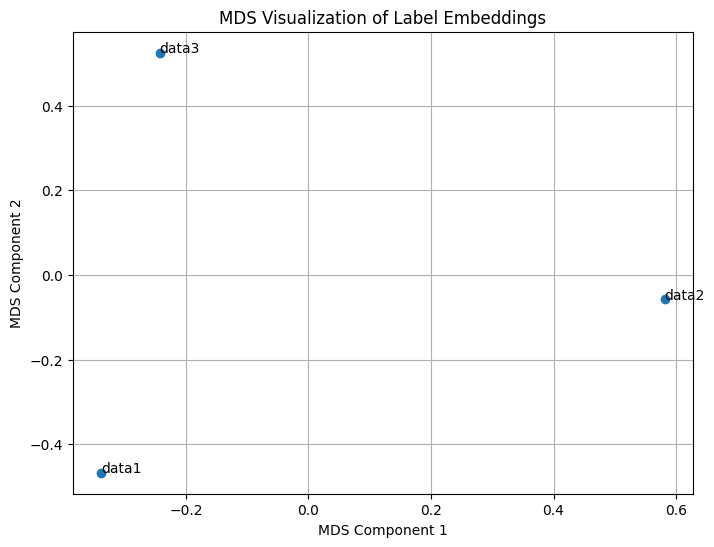

In [ ]:
# Get the label embeddings
m_label_embeddings = m_model.label_emb.detach().cpu().numpy()

# Compute similarity and distance matrices
m_similarity_matrix_labels = cosine_similarity(m_label_embeddings)
m_distance_matrix_labels = 1 - m_similarity_matrix_labels

# Perform MDS on label embeddings
mds_labels = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
m_mds_result_labels = mds_labels.fit_transform(m_distance_matrix_labels)

# Get the labels for plotting (0 and 1 in this case)
m_labels_for_plot = list(range(len(m_label_embeddings)))

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(m_mds_result_labels[:, 0], m_mds_result_labels[:, 1])

# Annotate points with labels
labelled=['data1', 'data2', 'data3']
for i, label in enumerate(m_labels_for_plot):
    plt.text(m_mds_result_labels[i, 0], m_mds_result_labels[i, 1], labelled[label])

plt.title('MDS Visualization of Label Embeddings')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.grid(True)
plt.show()